# 비지도학습 군집화 테스트

###  "사용 데이터 : 장르별 베스트셀러 리뷰 모음"
### 최적 토픽 갯수 테스트

### 조건
    * 각각의 ISBN끼리 리뷰를 합쳐서 테스트
    * 명사

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib

In [2]:
import konlpy
from konlpy.tag import Okt

In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 데이터 전처리

## 도서 리뷰 추가

In [5]:
import glob
import pandas as pd
from pandas.core.dtypes.missing import notnull
import nltk
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import re
from gensim.models import Word2Vec
from pandas import DataFrame
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## <전처리>

In [6]:
def cleansing(text):
    # text = str(text)
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)"  # e-mail 주소 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+"  # url 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "([^ㄷㅋㅎㅜㅠ가-힣a-zA-Z0-9])+"  # 한글 자음, 모음 제거 - without 'ㄷ,ㅋ,ㅎ,ㅜ,ㅠ'
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "<[^>]*>"  # html tag 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "[\r|\n]"  # \r, \n 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = re.compile(r"\s+")  # 이중 space 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    return text

### ISBN을 기준으로 리뷰를 모은 뒤 재조합

## <토큰화>

#### 분류 테스트 

In [7]:
okt = Okt()

----

### 기존 데이터 가져오기

In [8]:
# 불러오기
import pickle

book_morphs_with_isbn_pos_non_stopword = []
with open('data/detail_bestbook_unit_isbn_with_isbn_pos_non_stopword.txt', 'rb') as lf:
    book_morphs_with_isbn_pos_non_stopword = pickle.load(lf)
    
print(book_morphs_with_isbn_pos_non_stopword[0])

[9788959752195, [('내', 'Noun'), ('가제', 'Noun'), ('일', 'Noun'), ('좋아하다', 'Adjective'), ('책', 'Noun'), ('이', 'Noun'), ('당', 'Noun'), ('6', 'Number')]]


In [10]:
print(len(book_morphs_with_isbn_pos_non_stopword))
print(book_morphs_with_isbn_pos_non_stopword[2])

42559
[9791127420949, [('덕분', 'Noun'), ('에', 'Josa'), ('귀엽다', 'Adjective'), ('SD', 'Alpha'), ('를', 'Noun'), ('그릴', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective'), ('되어다', 'Verb'), ('너무', 'Adverb'), ('기쁘다', 'Adjective'), ('별', 'Noun'), ('5', 'Number'), ('개', 'Noun'), ('로', 'Noun'), ('도', 'Noun'), ('사실', 'Noun'), ('모자라다', 'Verb'), ('정도', 'Noun'), ('로', 'Noun'), ('좋다', 'Adjective'), ('책', 'Noun'), ('채색', 'Noun'), ('이', 'Noun'), ('없다', 'Adjective'), ('게', 'Noun'), ('좀', 'Noun'), ('아쉽다', 'Adjective'), ('채색', 'Noun'), ('책', 'Noun'), ('이', 'Noun'), ('아니다', 'Adjective'), ('별', 'Noun'), ('기대', 'Noun'), ('안', 'Noun'), ('하다', 'Verb'), ('생각', 'Noun'), ('보다', 'Verb'), ('내용', 'Noun'), ('이', 'Noun'), ('알차다', 'Adjective'), ('두고두고', 'Noun'), ('볼', 'Noun'), ('것', 'Noun'), ('같다', 'Adjective')]]


In [11]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','것','라고','에게','라면','을','이라',
             '라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있','죠','고','니','로','있','같',
             '어서','어요','는데','습니다','면서','많이','마','더','그렇다','의','당','좀','책','안','볼','게','안','정말','듯','이제야','여','요','게다가','같다',
            '임','로서','이제','만','인','붙이','그','저','수','가제','부터','닷','저희','적','알','쉬','못','꼭','살','제','권','제','분','나','내', '진작', '전', '뿐'
            , '대한','대해','책','좋다']

In [12]:
######### 태깅한 데이터 중에서 명사 +불용어 처리

book_train_nouns = []
book_train_isbn = []
for (isbn, test) in book_morphs_with_isbn_pos_non_stopword :
    tts = [(word,pos) for (word,pos) in test if not word in stopwords] #불용어 처리
    na = [word for (word,pos) in tts if pos in 'Noun'] # 명사만 저장

    if na : 
        book_train_nouns.append(na)
        book_train_isbn.append(isbn)

print('**********************END***************************')
print(len(book_train_nouns))
print(len(book_train_isbn))

**********************END***************************
42337
42337


In [13]:
for i in range(0,5) :
#     print(book_morphs_with_isbn_pos_non_stopword[i])
    print(book_train_nouns[i])

['일']
['처음', '제목', '보고', '예상', '스토리', '완전', '신간', '홀린', '장바구니', '사서', '맘', '사서', '걸', '조금', '여자', '이야기']
['덕분', '그릴', '별', '개', '사실', '정도', '채색', '채색', '별', '기대', '생각', '내용', '두고두고']
['구매', '쭉', '지리', '여행', '여행', '가기']
['요가', '궁극', '의미', '요가', '수행자', '위', '메시지', '방법', '과정', '자세', '설명', '알다', '정리', '매우', '서적', '요가', '공부', '위해', '구입', '공부', '도움', '요가', '교과서', '말', '요가', '백과사전', '식', '명작', '설명', '그림', '첨부', '재미', '실제', '응용', '위', '참고서', '아헹', '선생님', '요가', '알라딘', '쿠폰', '무료', '배송', '보아', '요가', '교과서', '최고', '요가', '입문', '무리']


----

## 최적 토픽의 수 테스트

In [35]:
from tqdm import tqdm 
import re 
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 
import logging 
import pickle 
import pyLDAvis.gensim 
from gensim.models.coherencemodel import CoherenceModel 
import matplotlib.pyplot as plt 


def compute_coherence_values(dictionary, corpus, texts, limit, start, step): 
    coherence_values = [] 
    model_list = [] 
    for num_topics in range(start, limit, step): 
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics) 
        model_list.append(model) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence())
        print('num_topics : ',num_topics)
    print('coherence_values : ',coherence_values)
    return model_list, coherence_values 
    
def find_optimal_number_of_topics(dictionary, corpus, processed_data): 
    limit = 40;
    start = 5; 
    step = 3; 

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best')
    plt.show() 

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-03-26 16:18:54,632 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-03-26 16:18:55,369 : INFO : adding document #10000 to Dictionary(28700 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 16:18:56,096 : INFO : adding document #20000 to Dictionary(38684 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 16:18:56,778 : INFO : adding document #30000 to Dictionary(45161 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 16:18:57,527 : INFO : adding document #40000 to Dictionary(51442 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 16:18:57,711

Number of unique tokens: 11814
Number of documents: 42337


2021-03-26 16:19:00,431 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:19:00,437 : INFO : topic #0 (0.200): 0.007*"아빠" + 0.005*"여성" + 0.003*"주인공" + 0.003*"김진명" + 0.003*"스토리" + 0.003*"개" + 0.003*"상상력" + 0.003*"사건" + 0.003*"엄마" + 0.002*"영화"
2021-03-26 16:19:00,437 : INFO : topic #1 (0.200): 0.004*"결정" + 0.004*"여행" + 0.003*"만화" + 0.003*"자기" + 0.003*"경주" + 0.003*"시인" + 0.003*"또한" + 0.002*"주인공" + 0.002*"그녀" + 0.002*"커피"
2021-03-26 16:19:00,438 : INFO : topic #2 (0.200): 0.006*"시집" + 0.003*"시인" + 0.003*"영어" + 0.003*"교재" + 0.003*"개" + 0.003*"감정" + 0.003*"이름" + 0.002*"중간" + 0.002*"뭔가" + 0.002*"깊이"
2021-03-26 16:19:00,438 : INFO : topic #3 (0.200): 0.012*"엄마" + 0.004*"아빠" + 0.004*"경주" + 0.004*"여행" + 0.004*"일본" + 0.003*"유통" + 0.003*"화가" + 0.003*"영어" + 0.003*"완전" + 0.003*"그림책"
2021-03-26 16:19:00,439 : INFO : topic #4 (0.200): 0.005*"도서관" + 0.004*"김진명" + 0.003*"만화" + 0.003*"여행" + 0.003*"하루키" + 0.003*"돈" + 0.003*"매력" + 0.003*"마지막" + 0.003*"페이지" + 0.002*"

2021-03-26 16:19:06,254 : INFO : topic #1 (0.200): 0.009*"여행" + 0.006*"고양이" + 0.005*"사진" + 0.004*"에세이" + 0.003*"음악" + 0.003*"과학" + 0.003*"나무" + 0.003*"그녀" + 0.003*"일상" + 0.003*"시선"
2021-03-26 16:19:06,255 : INFO : topic #2 (0.200): 0.007*"철학" + 0.006*"교재" + 0.006*"하루" + 0.005*"시인" + 0.004*"시집" + 0.004*"위로" + 0.004*"선생님" + 0.004*"나무" + 0.004*"준비" + 0.004*"시험"
2021-03-26 16:19:06,255 : INFO : topic #3 (0.200): 0.008*"엄마" + 0.008*"영어" + 0.007*"단어" + 0.005*"수학" + 0.005*"개념" + 0.004*"기본" + 0.004*"정보" + 0.004*"교육" + 0.004*"기초" + 0.004*"레시피"
2021-03-26 16:19:06,256 : INFO : topic #4 (0.200): 0.005*"만화" + 0.005*"가시" + 0.005*"매력" + 0.005*"영화" + 0.005*"추리소설" + 0.005*"반전" + 0.005*"스토리" + 0.005*"게이고" + 0.004*"드라마" + 0.004*"캐릭터"
2021-03-26 16:19:06,258 : INFO : topic diff=0.390590, rho=0.353553
2021-03-26 16:19:06,259 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:19:06,993 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:19:06,997 : INFO

2021-03-26 16:19:12,253 : INFO : topic #2 (0.200): 0.013*"교재" + 0.013*"연산" + 0.008*"시험" + 0.008*"준비" + 0.007*"문" + 0.007*"학습" + 0.007*"기출" + 0.006*"유형" + 0.006*"철학" + 0.006*"강의"
2021-03-26 16:19:12,254 : INFO : topic #3 (0.200): 0.012*"영어" + 0.008*"수학" + 0.008*"엄마" + 0.007*"개념" + 0.006*"단어" + 0.006*"기초" + 0.005*"기본" + 0.004*"지식" + 0.004*"입문" + 0.003*"교육"
2021-03-26 16:19:12,255 : INFO : topic #4 (0.200): 0.011*"만화" + 0.006*"소장" + 0.005*"매력" + 0.005*"스토리" + 0.004*"캐릭터" + 0.004*"편" + 0.004*"오" + 0.004*"주인공" + 0.004*"가격" + 0.003*"출판사"
2021-03-26 16:19:12,256 : INFO : topic diff=0.232296, rho=0.258199
2021-03-26 16:19:12,257 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:19:12,910 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:19:12,913 : INFO : topic #0 (0.200): 0.007*"영화" + 0.005*"어른" + 0.005*"그림책" + 0.004*"미래" + 0.004*"투자" + 0.004*"주식" + 0.004*"죽음" + 0.003*"여성" + 0.003*"꿈" + 0.003*"가슴"
2021-03-26 16:19:12,915 : INFO : topic 

2021-03-26 16:19:17,513 : INFO : topic #2 (0.200): 0.011*"교재" + 0.008*"철학" + 0.007*"단어" + 0.007*"학습" + 0.006*"문" + 0.006*"연습" + 0.006*"준비" + 0.006*"시험" + 0.006*"하루" + 0.005*"강의"
2021-03-26 16:19:17,514 : INFO : topic #3 (0.200): 0.012*"영어" + 0.008*"고전" + 0.007*"과학" + 0.006*"엄마" + 0.005*"지식" + 0.004*"수학" + 0.004*"교육" + 0.004*"경제" + 0.004*"단어" + 0.004*"개념"
2021-03-26 16:19:17,514 : INFO : topic #4 (0.200): 0.012*"만화" + 0.006*"스토리" + 0.005*"소장" + 0.005*"매력" + 0.005*"캐릭터" + 0.005*"주인공" + 0.004*"영화" + 0.004*"드라마" + 0.004*"페이지" + 0.004*"편"
2021-03-26 16:19:17,515 : INFO : topic diff=0.240474, rho=0.213201
2021-03-26 16:19:17,517 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:19:23,862 : INFO : 9 batches submitted to accumulate stats from 576 documents (-17693 virtual)
2021-03-26 16:19:23,871 : INFO : 11 batches submitted to accumulate stats from 704 documents (-17206 virtual)
2021-03-26 16:19:23,880 :

2021-03-26 16:19:26,857 : INFO : 405 batches submitted to accumulate stats from 25920 documents (-569064 virtual)
2021-03-26 16:19:26,866 : INFO : 406 batches submitted to accumulate stats from 25984 documents (-567874 virtual)
2021-03-26 16:19:26,873 : INFO : 408 batches submitted to accumulate stats from 26112 documents (-566992 virtual)
2021-03-26 16:19:26,881 : INFO : 409 batches submitted to accumulate stats from 26176 documents (-561208 virtual)
2021-03-26 16:19:26,887 : INFO : 410 batches submitted to accumulate stats from 26240 documents (-558669 virtual)
2021-03-26 16:19:26,922 : INFO : 413 batches submitted to accumulate stats from 26432 documents (-563158 virtual)
2021-03-26 16:19:27,082 : INFO : 427 batches submitted to accumulate stats from 27328 documents (-592186 virtual)
2021-03-26 16:19:27,175 : INFO : 441 batches submitted to accumulate stats from 28224 documents (-604872 virtual)
2021-03-26 16:19:27,232 : INFO : 446 batches submitted to accumulate stats from 28544 do

num_topics :  5
coherence_values :  [0.38810248394358976]


2021-03-26 16:19:29,199 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:19:29,204 : INFO : topic #6 (0.125): 0.006*"유통" + 0.005*"아빠" + 0.004*"이름" + 0.004*"결정" + 0.003*"돈" + 0.003*"화가" + 0.003*"사례" + 0.003*"킹" + 0.003*"자기" + 0.003*"사건"
2021-03-26 16:19:29,205 : INFO : topic #7 (0.125): 0.010*"경주" + 0.005*"여행" + 0.004*"단편" + 0.004*"교재" + 0.004*"시집" + 0.003*"사진" + 0.003*"하루키" + 0.003*"가격" + 0.003*"혼자" + 0.003*"그리스"
2021-03-26 16:19:29,205 : INFO : topic #1 (0.125): 0.004*"엄마" + 0.004*"영어" + 0.004*"김진명" + 0.004*"만화" + 0.004*"영화" + 0.003*"자기" + 0.003*"과학" + 0.003*"주인공" + 0.003*"여성" + 0.003*"고구려"
2021-03-26 16:19:29,206 : INFO : topic #5 (0.125): 0.004*"빵" + 0.003*"시집" + 0.003*"상상력" + 0.003*"그림책" + 0.003*"판" + 0.003*"감정" + 0.003*"가격" + 0.003*"출판사" + 0.003*"문학" + 0.003*"김진명"
2021-03-26 16:19:29,207 : INFO : topic #0 (0.125): 0.003*"투자" + 0.003*"옷" + 0.003*"청소년" + 0.003*"만화" + 0.002*"동화" + 0.002*"이상" + 0.002*"감" + 0.002*"체" + 0.002*"소재" + 0.002*"또한"
2

2021-03-26 16:19:34,645 : INFO : topic #2 (0.125): 0.005*"여행" + 0.005*"성경" + 0.005*"죽음" + 0.005*"시인" + 0.005*"철학" + 0.004*"고전" + 0.004*"운동" + 0.004*"에세이" + 0.003*"미국" + 0.003*"질문"
2021-03-26 16:19:34,646 : INFO : topic #4 (0.125): 0.021*"사진" + 0.020*"요리" + 0.019*"고양이" + 0.014*"와인" + 0.012*"레시피" + 0.011*"만화" + 0.009*"중국" + 0.009*"커피" + 0.008*"정보" + 0.007*"음식"
2021-03-26 16:19:34,647 : INFO : topic #1 (0.125): 0.011*"영화" + 0.007*"주인공" + 0.005*"마지막" + 0.005*"스토리" + 0.005*"인물" + 0.004*"사건" + 0.004*"전개" + 0.004*"매력" + 0.004*"드라마" + 0.004*"반전"
2021-03-26 16:19:34,648 : INFO : topic #0 (0.125): 0.010*"투자" + 0.007*"일본" + 0.006*"전쟁" + 0.005*"주식" + 0.004*"경제" + 0.004*"미래" + 0.004*"청소년" + 0.004*"치아" + 0.004*"부동산" + 0.004*"기자"
2021-03-26 16:19:34,649 : INFO : topic diff=0.373406, rho=0.353553
2021-03-26 16:19:34,649 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:19:35,305 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:19:35,310 : INFO 

2021-03-26 16:19:39,978 : INFO : topic #3 (0.125): 0.022*"영어" + 0.019*"교재" + 0.018*"연산" + 0.014*"단어" + 0.014*"학습" + 0.014*"엄마" + 0.013*"개념" + 0.010*"수학" + 0.009*"학년" + 0.008*"기초"
2021-03-26 16:19:39,979 : INFO : topic #1 (0.125): 0.010*"영화" + 0.006*"주인공" + 0.005*"마지막" + 0.005*"만화" + 0.005*"스토리" + 0.005*"매력" + 0.004*"여성" + 0.004*"인물" + 0.003*"전개" + 0.003*"사건"
2021-03-26 16:19:39,979 : INFO : topic #0 (0.125): 0.009*"미래" + 0.008*"투자" + 0.006*"일본" + 0.006*"전쟁" + 0.005*"주식" + 0.005*"건강" + 0.005*"경제" + 0.004*"주의" + 0.004*"돈" + 0.004*"현재"
2021-03-26 16:19:39,980 : INFO : topic diff=0.204401, rho=0.258199
2021-03-26 16:19:39,981 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:19:40,538 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:19:40,543 : INFO : topic #5 (0.125): 0.008*"그림책" + 0.007*"어른" + 0.005*"글쓰기" + 0.004*"소장" + 0.004*"위로" + 0.004*"동물" + 0.004*"가슴" + 0.004*"세" + 0.004*"시집" + 0.003*"추억"
2021-03-26 16:19:40,544 : INFO : topi

2021-03-26 16:19:44,642 : INFO : topic #3 (0.125): 0.032*"영어" + 0.016*"단어" + 0.016*"엄마" + 0.015*"교재" + 0.013*"학습" + 0.011*"수학" + 0.010*"학년" + 0.009*"개념" + 0.008*"연습" + 0.007*"강의"
2021-03-26 16:19:44,643 : INFO : topic #2 (0.125): 0.012*"고전" + 0.008*"여성혐오" + 0.008*"여성" + 0.007*"철학" + 0.005*"깊이" + 0.004*"독서" + 0.004*"지혜" + 0.004*"운동" + 0.004*"여행" + 0.004*"경험"
2021-03-26 16:19:44,644 : INFO : topic #4 (0.125): 0.025*"여행" + 0.022*"사진" + 0.019*"요리" + 0.016*"만화" + 0.016*"곡" + 0.015*"피아노" + 0.014*"음식" + 0.012*"레시피" + 0.012*"연주" + 0.010*"고양이"
2021-03-26 16:19:44,645 : INFO : topic diff=0.182553, rho=0.213201
2021-03-26 16:19:44,647 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:19:50,838 : INFO : 14 batches submitted to accumulate stats from 896 documents (-23733 virtual)
2021-03-26 16:19:50,877 : INFO : 26 batches submitted to accumulate stats from 1664 documents (-54266 virtual)
2021-03-26 16:19:50,92

2021-03-26 16:19:57,244 : INFO : PROGRESS: pass 0, at document #2000/42337


num_topics :  8
coherence_values :  [0.38810248394358976, 0.4411537296475936]


2021-03-26 16:19:58,192 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:19:58,199 : INFO : topic #0 (0.091): 0.005*"영어" + 0.003*"영화" + 0.003*"단어" + 0.003*"참고" + 0.003*"여성" + 0.003*"단편" + 0.002*"커피" + 0.002*"옷" + 0.002*"배경" + 0.002*"완전"
2021-03-26 16:19:58,200 : INFO : topic #7 (0.091): 0.004*"상상력" + 0.004*"그림책" + 0.004*"엄마" + 0.003*"완전" + 0.003*"소장" + 0.003*"고전" + 0.003*"아들" + 0.003*"판" + 0.003*"아빠" + 0.003*"페이지"
2021-03-26 16:19:58,200 : INFO : topic #3 (0.091): 0.011*"엄마" + 0.006*"여행" + 0.004*"결정" + 0.004*"투자" + 0.003*"수학" + 0.003*"스스로" + 0.003*"경주" + 0.003*"이기" + 0.003*"깊이" + 0.003*"영화"
2021-03-26 16:19:58,201 : INFO : topic #6 (0.091): 0.007*"도서관" + 0.006*"여행" + 0.005*"교재" + 0.005*"일본" + 0.005*"경주" + 0.004*"빵" + 0.004*"시집" + 0.003*"곳" + 0.003*"시인" + 0.003*"여성"
2021-03-26 16:19:58,201 : INFO : topic #10 (0.091): 0.008*"김진명" + 0.005*"시집" + 0.005*"감정" + 0.004*"시인" + 0.004*"화가" + 0.004*"이름" + 0.004*"도서관" + 0.003*"언제" + 0.003*"사진" + 0.003*"고구려"

2021-03-26 16:20:03,725 : INFO : topic #4 (0.091): 0.017*"엄마" + 0.011*"아들" + 0.011*"성경" + 0.010*"학년" + 0.009*"영어" + 0.009*"동화" + 0.008*"어른" + 0.008*"딸" + 0.008*"만화" + 0.007*"교재"
2021-03-26 16:20:03,726 : INFO : topic #2 (0.091): 0.013*"위로" + 0.011*"독서" + 0.009*"부모" + 0.008*"에세이" + 0.007*"재즈" + 0.007*"육아" + 0.006*"상처" + 0.006*"관계" + 0.006*"하루키" + 0.005*"엄마"
2021-03-26 16:20:03,727 : INFO : topic #5 (0.091): 0.025*"요리" + 0.017*"레시피" + 0.014*"한장" + 0.013*"하루" + 0.011*"매일" + 0.008*"수학" + 0.007*"주문" + 0.007*"문" + 0.007*"학년" + 0.007*"준비"
2021-03-26 16:20:03,727 : INFO : topic #3 (0.091): 0.014*"철학" + 0.008*"투자" + 0.005*"미래" + 0.005*"수학" + 0.005*"독서" + 0.005*"분석" + 0.005*"교육" + 0.005*"돈" + 0.005*"지식" + 0.004*"입문"
2021-03-26 16:20:03,728 : INFO : topic diff=0.299012, rho=0.353553
2021-03-26 16:20:03,729 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:20:04,391 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:20:04,398 : INFO : topic #

2021-03-26 16:20:09,093 : INFO : topic #6 (0.091): 0.036*"여행" + 0.023*"사진" + 0.010*"곳" + 0.007*"공기업" + 0.007*"세계사" + 0.006*"직접" + 0.006*"도시" + 0.006*"일본" + 0.006*"놀이" + 0.006*"음식"
2021-03-26 16:20:09,094 : INFO : topic #4 (0.091): 0.032*"엄마" + 0.017*"아들" + 0.014*"학년" + 0.012*"선생님" + 0.012*"어른" + 0.011*"초등" + 0.011*"딸" + 0.009*"학교" + 0.006*"동화" + 0.006*"초등학교"
2021-03-26 16:20:09,095 : INFO : topic #2 (0.091): 0.013*"위로" + 0.012*"글쓰기" + 0.009*"독서" + 0.009*"부모" + 0.008*"한국사" + 0.007*"자존감" + 0.007*"에세이" + 0.007*"육아" + 0.007*"용기" + 0.006*"상처"
2021-03-26 16:20:09,096 : INFO : topic diff=0.173529, rho=0.258199
2021-03-26 16:20:09,096 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:20:09,666 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:20:09,673 : INFO : topic #4 (0.091): 0.033*"엄마" + 0.018*"아들" + 0.015*"어른" + 0.013*"학년" + 0.013*"선생님" + 0.011*"딸" + 0.011*"초등" + 0.009*"학교" + 0.008*"동화" + 0.006*"초등학교"
2021-03-26 16:20:09,674 : INFO 

2021-03-26 16:20:13,830 : INFO : topic #8 (0.091): 0.019*"곡" + 0.018*"피아노" + 0.014*"연주" + 0.013*"그리스" + 0.012*"디자인" + 0.011*"음악" + 0.009*"악보" + 0.008*"미술" + 0.007*"로마" + 0.006*"마케팅"
2021-03-26 16:20:13,831 : INFO : topic #3 (0.091): 0.014*"과학" + 0.012*"철학" + 0.010*"미래" + 0.007*"지식" + 0.006*"고전" + 0.005*"분석" + 0.005*"경제" + 0.005*"변화" + 0.005*"돈" + 0.005*"관점"
2021-03-26 16:20:13,832 : INFO : topic #7 (0.091): 0.019*"만화" + 0.016*"고전" + 0.010*"소장" + 0.007*"그림책" + 0.006*"스토리" + 0.005*"종이" + 0.005*"판" + 0.005*"가격" + 0.005*"동물" + 0.005*"배송"
2021-03-26 16:20:13,833 : INFO : topic diff=0.173873, rho=0.213201
2021-03-26 16:20:13,835 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:20:20,008 : INFO : 11 batches submitted to accumulate stats from 704 documents (-28486 virtual)
2021-03-26 16:20:20,013 : INFO : 13 batches submitted to accumulate stats from 832 documents (-29453 virtual)
2021-03-26 16:20:20,017 

num_topics :  11
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074]


2021-03-26 16:20:28,903 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:20:28,912 : INFO : topic #8 (0.071): 0.009*"시집" + 0.005*"한자" + 0.004*"시인" + 0.004*"엄마" + 0.004*"여성" + 0.003*"개" + 0.003*"교재" + 0.003*"급" + 0.003*"페이지" + 0.003*"아들"
2021-03-26 16:20:28,913 : INFO : topic #9 (0.071): 0.006*"화가" + 0.005*"죽음" + 0.005*"엄마" + 0.004*"청소년" + 0.004*"주인공" + 0.004*"체" + 0.003*"출판사" + 0.003*"가슴" + 0.003*"그것" + 0.003*"동화"
2021-03-26 16:20:28,913 : INFO : topic #11 (0.071): 0.005*"엄마" + 0.004*"만화" + 0.004*"개" + 0.004*"여행" + 0.004*"경주" + 0.003*"주인공" + 0.003*"경제" + 0.003*"캐릭터" + 0.003*"기탄" + 0.003*"공지영"
2021-03-26 16:20:28,914 : INFO : topic #0 (0.071): 0.005*"일본" + 0.004*"김진명" + 0.004*"영화" + 0.003*"교재" + 0.003*"시험" + 0.003*"소재" + 0.003*"존재" + 0.003*"글쓰기" + 0.003*"사진" + 0.002*"학습"
2021-03-26 16:20:28,914 : INFO : topic #3 (0.071): 0.006*"아빠" + 0.005*"만화" + 0.004*"영어" + 0.004*"단편" + 0.004*"체" + 0.004*"엄마" + 0.003*"감정" + 0.003*"생기" + 0.003*"문" + 0.003*"장"
2

2021-03-26 16:20:34,365 : INFO : topic #13 (0.071): 0.017*"철학" + 0.012*"독서" + 0.005*"질문" + 0.004*"실천" + 0.004*"깊이" + 0.004*"철학자" + 0.004*"사상" + 0.004*"법칙" + 0.004*"기술" + 0.004*"교수"
2021-03-26 16:20:34,366 : INFO : topic #9 (0.071): 0.021*"죽음" + 0.015*"와인" + 0.011*"음악" + 0.010*"청소년" + 0.008*"미술" + 0.005*"폭력" + 0.005*"인물" + 0.005*"진실" + 0.004*"가슴" + 0.004*"곡"
2021-03-26 16:20:34,366 : INFO : topic #8 (0.071): 0.021*"교재" + 0.015*"학습" + 0.011*"시험" + 0.009*"시집" + 0.009*"국어" + 0.009*"단어" + 0.009*"준비" + 0.008*"문법" + 0.008*"개념" + 0.007*"문"
2021-03-26 16:20:34,367 : INFO : topic #4 (0.071): 0.023*"나무" + 0.014*"사진" + 0.011*"엄마" + 0.010*"어른" + 0.010*"그림책" + 0.010*"동물" + 0.010*"아기" + 0.009*"꿈" + 0.009*"위로" + 0.008*"컬러"
2021-03-26 16:20:34,368 : INFO : topic diff=0.308407, rho=0.353553
2021-03-26 16:20:34,369 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:20:35,032 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:20:35,040 : INFO : topic 

2021-03-26 16:20:39,711 : INFO : topic #13 (0.071): 0.014*"철학" + 0.008*"독서" + 0.006*"기술" + 0.005*"실천" + 0.005*"지식" + 0.005*"경험" + 0.005*"깊이" + 0.005*"이론" + 0.005*"질문" + 0.004*"입문"
2021-03-26 16:20:39,712 : INFO : topic #6 (0.071): 0.041*"여행" + 0.027*"과학" + 0.009*"에세이" + 0.008*"가격" + 0.007*"곳" + 0.006*"출판사" + 0.005*"풀기" + 0.005*"편집" + 0.005*"우주" + 0.004*"디자인"
2021-03-26 16:20:39,712 : INFO : topic #7 (0.071): 0.025*"요리" + 0.023*"음식" + 0.017*"레시피" + 0.015*"선생님" + 0.012*"맛" + 0.011*"자존감" + 0.009*"재료" + 0.007*"사진" + 0.007*"할머니" + 0.006*"밥"
2021-03-26 16:20:39,714 : INFO : topic diff=0.174958, rho=0.258199
2021-03-26 16:20:39,714 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:20:40,306 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:20:40,314 : INFO : topic #13 (0.071): 0.013*"철학" + 0.007*"독서" + 0.006*"기술" + 0.005*"실천" + 0.005*"질문" + 0.005*"지식" + 0.005*"사례" + 0.005*"이론" + 0.005*"교수" + 0.005*"깊이"
2021-03-26 16:20:40,315 : INFO : t

2021-03-26 16:20:44,484 : INFO : topic #0 (0.071): 0.018*"일본" + 0.015*"글쓰기" + 0.012*"디자인" + 0.009*"배송" + 0.009*"판" + 0.008*"소장" + 0.008*"완결" + 0.007*"출판사" + 0.007*"가격" + 0.006*"상태"
2021-03-26 16:20:44,485 : INFO : topic #1 (0.071): 0.016*"상상력" + 0.014*"동화" + 0.013*"상상" + 0.009*"층" + 0.009*"어른" + 0.008*"동양" + 0.007*"도시" + 0.006*"왕" + 0.006*"전치사" + 0.006*"빵"
2021-03-26 16:20:44,485 : INFO : topic #7 (0.071): 0.026*"요리" + 0.020*"음식" + 0.016*"레시피" + 0.016*"정세랑" + 0.013*"선생님" + 0.012*"맛" + 0.009*"재료" + 0.008*"건축" + 0.008*"술" + 0.007*"박민규"
2021-03-26 16:20:44,487 : INFO : topic diff=0.153875, rho=0.213201
2021-03-26 16:20:44,490 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:20:50,676 : INFO : 15 batches submitted to accumulate stats from 960 documents (-31534 virtual)
2021-03-26 16:20:50,839 : INFO : 34 batches submitted to accumulate stats from 2176 documents (-74373 virtual)
2021-03-26 16:20:50,937

num_topics :  14
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801]


2021-03-26 16:21:00,378 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:21:00,388 : INFO : topic #8 (0.059): 0.017*"경주" + 0.009*"여행" + 0.008*"김진명" + 0.005*"시집" + 0.004*"완전" + 0.004*"지식" + 0.003*"주인공" + 0.003*"이상" + 0.003*"시인" + 0.003*"화가"
2021-03-26 16:21:00,389 : INFO : topic #1 (0.059): 0.006*"여성" + 0.006*"체" + 0.005*"동화" + 0.004*"이름" + 0.004*"힐링" + 0.003*"시인" + 0.003*"주인공" + 0.003*"게임" + 0.003*"캐릭터" + 0.003*"만화"
2021-03-26 16:21:00,389 : INFO : topic #16 (0.059): 0.017*"아빠" + 0.006*"일본" + 0.005*"엄마" + 0.004*"한자" + 0.004*"만화" + 0.004*"자기" + 0.004*"곳" + 0.004*"술" + 0.003*"스티커" + 0.003*"영어"
2021-03-26 16:21:00,390 : INFO : topic #9 (0.059): 0.009*"유통" + 0.009*"여행" + 0.006*"시집" + 0.003*"시인" + 0.003*"출판사" + 0.003*"가슴" + 0.003*"마지막" + 0.003*"문학" + 0.003*"일본" + 0.003*"지식"
2021-03-26 16:21:00,391 : INFO : topic #7 (0.059): 0.007*"영어" + 0.005*"엄마" + 0.004*"장" + 0.003*"학습" + 0.003*"교재" + 0.003*"생활" + 0.003*"강의" + 0.003*"구" + 0.003*"이상" + 0.002*"명"
20

2021-03-26 16:21:05,672 : INFO : topic #15 (0.059): 0.011*"주인공" + 0.008*"가시" + 0.008*"사건" + 0.008*"반전" + 0.008*"게이고" + 0.007*"전개" + 0.007*"추리소설" + 0.007*"영화" + 0.006*"드라마" + 0.006*"스릴러"
2021-03-26 16:21:05,673 : INFO : topic #9 (0.059): 0.016*"여행" + 0.009*"시인" + 0.008*"일본" + 0.007*"시집" + 0.005*"사상" + 0.005*"기자" + 0.005*"나라" + 0.004*"깊이" + 0.004*"곳" + 0.004*"가슴"
2021-03-26 16:21:05,673 : INFO : topic #8 (0.059): 0.040*"나무" + 0.034*"사진" + 0.031*"요리" + 0.026*"레시피" + 0.018*"음악" + 0.011*"꽃" + 0.011*"이름" + 0.011*"여행" + 0.009*"직접" + 0.009*"재료"
2021-03-26 16:21:05,674 : INFO : topic #2 (0.059): 0.022*"투자" + 0.013*"돈" + 0.012*"주식" + 0.008*"부자" + 0.008*"부동산" + 0.007*"경제" + 0.007*"토익" + 0.005*"가치" + 0.005*"분석" + 0.005*"사업"
2021-03-26 16:21:05,675 : INFO : topic diff=0.339878, rho=0.353553
2021-03-26 16:21:05,676 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:21:06,333 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:21:06,344 : INFO : t

2021-03-26 16:21:10,981 : INFO : topic #12 (0.059): 0.033*"철학" + 0.028*"과학" + 0.025*"고양이" + 0.011*"입문" + 0.010*"죽음" + 0.008*"주의" + 0.008*"신" + 0.006*"인류" + 0.006*"경제학" + 0.006*"이론"
2021-03-26 16:21:10,981 : INFO : topic #9 (0.059): 0.011*"여행" + 0.007*"시인" + 0.007*"일본" + 0.006*"시집" + 0.005*"깊이" + 0.005*"나라" + 0.005*"교수" + 0.005*"곳" + 0.004*"문화" + 0.004*"가슴"
2021-03-26 16:21:10,982 : INFO : topic #0 (0.059): 0.024*"만화" + 0.012*"한국사" + 0.010*"편" + 0.008*"중국어" + 0.007*"공기업" + 0.007*"오" + 0.006*"사" + 0.005*"스토리" + 0.005*"주문" + 0.005*"정발"
2021-03-26 16:21:10,984 : INFO : topic diff=0.184170, rho=0.258199
2021-03-26 16:21:10,984 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:21:11,551 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:21:11,562 : INFO : topic #14 (0.059): 0.026*"독해" + 0.014*"독해력" + 0.014*"지문" + 0.013*"지식" + 0.012*"문학" + 0.011*"세계사" + 0.011*"미술" + 0.009*"어휘" + 0.008*"인문학" + 0.007*"수능"
2021-03-26 16:21:11,563 : INFO : t

2021-03-26 16:21:15,854 : INFO : topic #14 (0.059): 0.021*"지도" + 0.016*"지식" + 0.012*"미술" + 0.012*"독해" + 0.010*"인문학" + 0.010*"문학" + 0.009*"미국" + 0.008*"문화" + 0.008*"자료" + 0.008*"문명"
2021-03-26 16:21:15,855 : INFO : topic #8 (0.059): 0.055*"여행" + 0.041*"사진" + 0.030*"요리" + 0.025*"곡" + 0.020*"레시피" + 0.019*"문어" + 0.017*"나무" + 0.016*"음악" + 0.013*"직접" + 0.012*"악보"
2021-03-26 16:21:15,856 : INFO : topic #16 (0.059): 0.030*"동물" + 0.015*"놀이" + 0.012*"북" + 0.012*"음식" + 0.011*"혼자" + 0.009*"취미" + 0.009*"일본" + 0.008*"한자" + 0.008*"앤" + 0.007*"발레"
2021-03-26 16:21:15,857 : INFO : topic diff=0.162329, rho=0.213201
2021-03-26 16:21:15,862 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:21:22,055 : INFO : 15 batches submitted to accumulate stats from 960 documents (-35408 virtual)
2021-03-26 16:21:22,065 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-34904 virtual)
2021-03-26 16:21:22,288 :

num_topics :  17
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984]


2021-03-26 16:21:34,795 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:21:34,806 : INFO : topic #4 (0.050): 0.008*"화가" + 0.007*"엄마" + 0.005*"이름" + 0.004*"동물" + 0.004*"만화" + 0.004*"도서관" + 0.003*"딸" + 0.003*"명작" + 0.003*"감정" + 0.003*"첫"
2021-03-26 16:21:34,807 : INFO : topic #6 (0.050): 0.022*"아빠" + 0.009*"빵" + 0.006*"엄마" + 0.006*"아들" + 0.006*"한자" + 0.005*"종이" + 0.005*"기탄" + 0.005*"상상력" + 0.004*"그림책" + 0.004*"구름"
2021-03-26 16:21:34,808 : INFO : topic #8 (0.050): 0.010*"엄마" + 0.006*"김진명" + 0.006*"돈" + 0.005*"죽음" + 0.004*"감정" + 0.004*"걱정" + 0.003*"단편" + 0.003*"선택" + 0.003*"문학" + 0.003*"하루키"
2021-03-26 16:21:34,809 : INFO : topic #10 (0.050): 0.005*"일본" + 0.004*"만화" + 0.004*"단편" + 0.004*"사진" + 0.003*"깊이" + 0.003*"시인" + 0.003*"커피" + 0.003*"문학" + 0.003*"언제" + 0.003*"영화"
2021-03-26 16:21:34,810 : INFO : topic #16 (0.050): 0.004*"결정" + 0.004*"주식" + 0.004*"하루키" + 0.004*"손" + 0.004*"아빠" + 0.003*"그림책" + 0.003*"육아" + 0.003*"여성" + 0.003*"가치" + 0.003*"엄마"


2021-03-26 16:21:40,149 : INFO : topic #4 (0.050): 0.032*"고양이" + 0.015*"동물" + 0.014*"미술" + 0.005*"미술사" + 0.005*"고래" + 0.005*"헤겔" + 0.005*"시선" + 0.004*"노래" + 0.004*"이름" + 0.004*"예술"
2021-03-26 16:21:40,149 : INFO : topic #16 (0.050): 0.018*"투자" + 0.014*"글쓰기" + 0.011*"돈" + 0.010*"주식" + 0.010*"육아" + 0.008*"뇌" + 0.007*"자기" + 0.007*"차" + 0.006*"여성" + 0.006*"가치"
2021-03-26 16:21:40,150 : INFO : topic #15 (0.050): 0.019*"과학" + 0.011*"커피" + 0.009*"법칙" + 0.008*"디자인" + 0.007*"패턴" + 0.006*"옷" + 0.006*"실천" + 0.006*"사진" + 0.005*"운동" + 0.005*"행동"
2021-03-26 16:21:40,151 : INFO : topic #14 (0.050): 0.051*"수학" + 0.016*"배송" + 0.015*"주문" + 0.010*"곡" + 0.010*"예약" + 0.010*"기초" + 0.009*"게임" + 0.008*"통계학" + 0.008*"코드" + 0.007*"문법"
2021-03-26 16:21:40,152 : INFO : topic diff=0.379874, rho=0.353553
2021-03-26 16:21:40,153 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:21:40,801 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:21:40,814 : INFO : topi

2021-03-26 16:21:45,643 : INFO : topic #19 (0.050): 0.016*"신화" + 0.011*"그리스" + 0.010*"로마" + 0.009*"사전" + 0.009*"소" + 0.008*"소장" + 0.008*"가격" + 0.007*"메리" + 0.007*"약" + 0.007*"종이"
2021-03-26 16:21:45,644 : INFO : topic #11 (0.050): 0.087*"여행" + 0.034*"사진" + 0.016*"파이썬" + 0.015*"정보" + 0.014*"훈련" + 0.014*"초보자" + 0.013*"곳" + 0.012*"할머니" + 0.010*"와인" + 0.010*"프로그래밍"
2021-03-26 16:21:45,645 : INFO : topic #12 (0.050): 0.018*"음악" + 0.017*"오" + 0.017*"북" + 0.016*"디자인" + 0.015*"일러스트" + 0.014*"컬러" + 0.011*"판" + 0.010*"색칠" + 0.010*"색" + 0.009*"종이"
2021-03-26 16:21:45,646 : INFO : topic diff=0.199549, rho=0.258199
2021-03-26 16:21:45,647 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:21:46,191 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:21:46,203 : INFO : topic #12 (0.050): 0.020*"디자인" + 0.019*"오" + 0.018*"음악" + 0.018*"북" + 0.015*"일러스트" + 0.014*"컬러" + 0.012*"판" + 0.010*"색" + 0.009*"종이" + 0.009*"가격"
2021-03-26 16:21:46,204 : INFO : t

2021-03-26 16:21:50,428 : INFO : topic #2 (0.050): 0.023*"청소년" + 0.020*"중국" + 0.014*"지도" + 0.012*"직업" + 0.009*"기업" + 0.007*"꿈" + 0.007*"인터뷰" + 0.007*"사장" + 0.007*"조선" + 0.007*"운"
2021-03-26 16:21:50,429 : INFO : topic #0 (0.050): 0.031*"철학" + 0.012*"인류" + 0.012*"지식" + 0.010*"전쟁" + 0.010*"관점" + 0.009*"인문학" + 0.009*"우주" + 0.008*"시각" + 0.008*"해석" + 0.008*"교수"
2021-03-26 16:21:50,430 : INFO : topic #15 (0.050): 0.054*"과학" + 0.015*"심리학" + 0.013*"운동" + 0.012*"뇌" + 0.008*"박사" + 0.007*"행동" + 0.007*"실험" + 0.007*"심리" + 0.006*"디자인" + 0.006*"과학자"
2021-03-26 16:21:50,431 : INFO : topic diff=0.158242, rho=0.213201
2021-03-26 16:21:50,436 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:21:56,711 : INFO : 15 batches submitted to accumulate stats from 960 documents (-34936 virtual)
2021-03-26 16:21:56,716 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-34812 virtual)
2021-03-26 16:21:56,93

num_topics :  20
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984, 0.4749615222911377]


2021-03-26 16:22:10,872 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:22:10,887 : INFO : topic #15 (0.043): 0.008*"화가" + 0.004*"이름" + 0.004*"감정" + 0.004*"김진명" + 0.004*"체" + 0.004*"소재" + 0.004*"아기" + 0.003*"디자인" + 0.003*"철학" + 0.003*"일상"
2021-03-26 16:22:10,888 : INFO : topic #18 (0.043): 0.008*"여성" + 0.005*"독서" + 0.004*"영어" + 0.004*"영화" + 0.004*"주인공" + 0.004*"딸" + 0.004*"뒤" + 0.003*"출판사" + 0.003*"상" + 0.003*"모임"
2021-03-26 16:22:10,889 : INFO : topic #0 (0.043): 0.007*"영어" + 0.007*"하루키" + 0.006*"술" + 0.005*"엄마" + 0.004*"단편" + 0.004*"여행" + 0.003*"가슴" + 0.003*"문학" + 0.003*"시인" + 0.003*"청소년"
2021-03-26 16:22:10,889 : INFO : topic #13 (0.043): 0.013*"엄마" + 0.005*"빵" + 0.004*"킹" + 0.004*"체" + 0.004*"스티븐" + 0.004*"영화" + 0.003*"아빠" + 0.003*"스토리" + 0.003*"공지영" + 0.003*"주인공"
2021-03-26 16:22:10,890 : INFO : topic #11 (0.043): 0.005*"영화" + 0.004*"수학" + 0.004*"나라" + 0.003*"완전" + 0.003*"반" + 0.003*"돈" + 0.003*"판" + 0.003*"관" + 0.003*"김진명" + 0.003*"매력"
2

2021-03-26 16:22:16,472 : INFO : topic #6 (0.043): 0.024*"와인" + 0.016*"중국" + 0.012*"지식" + 0.009*"정보" + 0.009*"약" + 0.009*"유튜브" + 0.008*"게임" + 0.006*"에코" + 0.006*"이벤트" + 0.006*"개"
2021-03-26 16:22:16,473 : INFO : topic #20 (0.043): 0.015*"스릴러" + 0.010*"인형" + 0.007*"컬러" + 0.007*"주인공" + 0.007*"동화" + 0.007*"패턴" + 0.007*"심리" + 0.007*"몰입" + 0.007*"타" + 0.006*"소재"
2021-03-26 16:22:16,474 : INFO : topic #18 (0.043): 0.040*"나무" + 0.037*"독서" + 0.008*"리더" + 0.008*"이름" + 0.007*"필사" + 0.006*"쓰기" + 0.005*"영화" + 0.005*"변화" + 0.005*"습관" + 0.004*"숲"
2021-03-26 16:22:16,475 : INFO : topic #3 (0.043): 0.018*"개념" + 0.012*"일본" + 0.012*"문" + 0.011*"국어" + 0.010*"이론" + 0.010*"세계사" + 0.009*"시험" + 0.009*"준비" + 0.009*"교육" + 0.008*"해설"
2021-03-26 16:22:16,476 : INFO : topic diff=0.406010, rho=0.353553
2021-03-26 16:22:16,477 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:22:17,162 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:22:17,177 : INFO : topic

2021-03-26 16:22:22,096 : INFO : topic #18 (0.043): 0.040*"독서" + 0.015*"나무" + 0.012*"글쓰기" + 0.011*"리더" + 0.010*"필사" + 0.009*"메리" + 0.009*"리더십" + 0.007*"자연" + 0.007*"대화" + 0.007*"쓰기"
2021-03-26 16:22:22,097 : INFO : topic #22 (0.043): 0.044*"수학" + 0.029*"학년" + 0.020*"초등" + 0.016*"학교" + 0.015*"교재" + 0.014*"아들" + 0.014*"놀이" + 0.010*"계산" + 0.010*"수업" + 0.010*"초"
2021-03-26 16:22:22,098 : INFO : topic #19 (0.043): 0.068*"연산" + 0.031*"요리" + 0.026*"음식" + 0.023*"레시피" + 0.017*"과학" + 0.014*"맛" + 0.013*"원리" + 0.013*"한자" + 0.011*"뇌" + 0.009*"재료"
2021-03-26 16:22:22,101 : INFO : topic diff=0.215839, rho=0.258199
2021-03-26 16:22:22,102 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:22:22,693 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:22:22,709 : INFO : topic #2 (0.043): 0.077*"여행" + 0.045*"사진" + 0.018*"경제" + 0.016*"미술" + 0.014*"곳" + 0.014*"문화" + 0.014*"코로나" + 0.012*"도시" + 0.012*"건축" + 0.011*"경제학"
2021-03-26 16:22:22,710 : INFO : top

2021-03-26 16:22:27,180 : INFO : topic #20 (0.043): 0.013*"심리" + 0.013*"반전" + 0.013*"몰입" + 0.011*"회화" + 0.010*"소재" + 0.009*"패턴" + 0.009*"타" + 0.009*"스릴러" + 0.009*"전개" + 0.008*"스토리"
2021-03-26 16:22:27,181 : INFO : topic #16 (0.043): 0.025*"동물" + 0.024*"돈" + 0.022*"문어" + 0.012*"용기" + 0.009*"사장" + 0.009*"목소리" + 0.009*"회사" + 0.009*"응원" + 0.008*"자기계발" + 0.008*"마케팅"
2021-03-26 16:22:27,182 : INFO : topic #17 (0.043): 0.075*"영어" + 0.036*"단어" + 0.029*"교재" + 0.023*"학습" + 0.020*"연습" + 0.019*"강의" + 0.017*"기초" + 0.015*"문법" + 0.014*"일본어" + 0.014*"그리스"
2021-03-26 16:22:27,184 : INFO : topic diff=0.163509, rho=0.213201
2021-03-26 16:22:27,190 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:22:33,494 : INFO : 12 batches submitted to accumulate stats from 768 documents (-34646 virtual)
2021-03-26 16:22:33,512 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-35178 virtual)
2021-03-26 16:22:

num_topics :  23
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984, 0.4749615222911377, 0.40991808070316443]


2021-03-26 16:22:50,444 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:22:50,460 : INFO : topic #16 (0.038): 0.007*"한자" + 0.006*"옷" + 0.006*"급" + 0.004*"패턴" + 0.004*"과정" + 0.003*"피아노" + 0.003*"현재" + 0.003*"영어" + 0.003*"반복" + 0.003*"세"
2021-03-26 16:22:50,461 : INFO : topic #23 (0.038): 0.012*"공지영" + 0.007*"만화" + 0.005*"위로" + 0.004*"화가" + 0.003*"사례" + 0.003*"주식" + 0.003*"미술" + 0.003*"인터뷰" + 0.003*"그리스" + 0.003*"가격"
2021-03-26 16:22:50,462 : INFO : topic #4 (0.038): 0.009*"아빠" + 0.007*"세계사" + 0.005*"옷" + 0.005*"김진명" + 0.004*"그림책" + 0.004*"편" + 0.004*"패턴" + 0.004*"몰입" + 0.004*"꽃" + 0.004*"선생님"
2021-03-26 16:22:50,463 : INFO : topic #12 (0.038): 0.010*"김진명" + 0.005*"영어" + 0.004*"레시피" + 0.004*"상상력" + 0.003*"요리" + 0.003*"전개" + 0.003*"사건" + 0.003*"걱정" + 0.003*"엄마" + 0.003*"소재"
2021-03-26 16:22:50,464 : INFO : topic #2 (0.038): 0.007*"수학" + 0.006*"결정" + 0.004*"여성" + 0.004*"구" + 0.004*"카페" + 0.003*"그림책" + 0.003*"체르니" + 0.003*"출판사" + 0.003*"긍정" + 0.003

2021-03-26 16:22:56,052 : INFO : topic #3 (0.038): 0.033*"개념" + 0.029*"학년" + 0.026*"문" + 0.024*"어휘" + 0.020*"학습" + 0.019*"쓰기" + 0.019*"수학" + 0.019*"커피" + 0.017*"교재" + 0.016*"초등"
2021-03-26 16:22:56,052 : INFO : topic #20 (0.038): 0.021*"중국" + 0.012*"몸" + 0.012*"킹" + 0.012*"폭력" + 0.008*"글쓰기" + 0.006*"건강" + 0.006*"연필" + 0.005*"기도" + 0.005*"베이" + 0.005*"문구"
2021-03-26 16:22:56,053 : INFO : topic #24 (0.038): 0.058*"단어" + 0.020*"하루" + 0.018*"용" + 0.018*"법칙" + 0.017*"컬러" + 0.015*"스트레스" + 0.014*"작성" + 0.013*"준비" + 0.013*"놀이" + 0.013*"북"
2021-03-26 16:22:56,054 : INFO : topic #19 (0.038): 0.021*"세트" + 0.018*"여주" + 0.017*"나무" + 0.016*"박스" + 0.015*"에코" + 0.012*"주문" + 0.012*"개미" + 0.011*"니체" + 0.010*"숲" + 0.008*"이름"
2021-03-26 16:22:56,056 : INFO : topic diff=0.434132, rho=0.353553
2021-03-26 16:22:56,056 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:22:56,736 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:22:56,754 : INFO : topic #

2021-03-26 16:23:01,602 : INFO : topic #21 (0.038): 0.040*"엄마" + 0.014*"부모" + 0.012*"선생님" + 0.011*"영어" + 0.010*"실천" + 0.010*"생활" + 0.009*"자존감" + 0.009*"육아" + 0.008*"습관" + 0.007*"교육"
2021-03-26 16:23:01,603 : INFO : topic #25 (0.038): 0.017*"시인" + 0.016*"시집" + 0.014*"가슴" + 0.008*"필사" + 0.008*"감성" + 0.008*"눈물" + 0.007*"슬픔" + 0.006*"위로" + 0.006*"고통" + 0.006*"이름"
2021-03-26 16:23:01,603 : INFO : topic #1 (0.038): 0.027*"고전" + 0.022*"일본어" + 0.016*"판" + 0.016*"출판사" + 0.010*"소장" + 0.010*"가격" + 0.010*"원서" + 0.009*"명작" + 0.008*"가치" + 0.008*"개정판"
2021-03-26 16:23:01,605 : INFO : topic diff=0.230099, rho=0.258199
2021-03-26 16:23:01,606 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:23:02,188 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:23:02,205 : INFO : topic #16 (0.038): 0.035*"영어" + 0.030*"교재" + 0.024*"강의" + 0.020*"기초" + 0.020*"기본" + 0.015*"독해" + 0.015*"시험" + 0.012*"문법" + 0.012*"사용" + 0.012*"학습"
2021-03-26 16:23:02,206 : INFO : 

2021-03-26 16:23:06,653 : INFO : topic #19 (0.038): 0.027*"숲" + 0.022*"주문" + 0.021*"노래" + 0.019*"사전" + 0.019*"여사" + 0.018*"수행" + 0.017*"박스" + 0.014*"세트" + 0.013*"블로그" + 0.012*"니체"
2021-03-26 16:23:06,654 : INFO : topic #9 (0.038): 0.011*"단편" + 0.010*"문학" + 0.008*"정세랑" + 0.007*"순간" + 0.007*"단" + 0.006*"편집" + 0.006*"일상" + 0.005*"존재" + 0.005*"매력" + 0.005*"그것"
2021-03-26 16:23:06,654 : INFO : topic #20 (0.038): 0.043*"중국" + 0.034*"몸" + 0.015*"킹" + 0.013*"기도" + 0.012*"건강" + 0.011*"기독교" + 0.011*"베이" + 0.007*"낭비" + 0.006*"연필" + 0.006*"폭력"
2021-03-26 16:23:06,656 : INFO : topic diff=0.182163, rho=0.213201
2021-03-26 16:23:06,663 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:23:12,853 : INFO : 12 batches submitted to accumulate stats from 768 documents (-35117 virtual)
2021-03-26 16:23:12,869 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-36241 virtual)
2021-03-26 16:23:13,169 :

num_topics :  26
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984, 0.4749615222911377, 0.40991808070316443, 0.45882209037141397]


2021-03-26 16:23:31,175 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:23:31,194 : INFO : topic #8 (0.034): 0.005*"과학" + 0.005*"마지막" + 0.004*"학습" + 0.003*"깊이" + 0.003*"소장" + 0.003*"단편" + 0.003*"한자" + 0.003*"현재" + 0.003*"시집" + 0.003*"인물"
2021-03-26 16:23:31,194 : INFO : topic #13 (0.034): 0.015*"경주" + 0.013*"여행" + 0.010*"한자" + 0.006*"여성" + 0.006*"체" + 0.006*"영어" + 0.005*"혼자" + 0.005*"동화" + 0.004*"파리" + 0.004*"사진"
2021-03-26 16:23:31,195 : INFO : topic #16 (0.034): 0.042*"아빠" + 0.010*"종이" + 0.009*"일본" + 0.005*"패턴" + 0.004*"엄마" + 0.004*"그림책" + 0.004*"영어" + 0.004*"옷" + 0.003*"가족" + 0.003*"아버지"
2021-03-26 16:23:31,196 : INFO : topic #14 (0.034): 0.006*"영화" + 0.004*"엄마" + 0.004*"오" + 0.004*"미래" + 0.003*"페이지" + 0.003*"완전" + 0.003*"오늘" + 0.003*"기도" + 0.003*"다만" + 0.003*"가치"
2021-03-26 16:23:31,197 : INFO : topic #21 (0.034): 0.007*"딸" + 0.005*"엄마" + 0.004*"문학" + 0.004*"세계사" + 0.004*"형" + 0.003*"소재" + 0.003*"전개" + 0.003*"가슴" + 0.003*"선택" + 0.003*"캐릭터"

2021-03-26 16:23:36,864 : INFO : topic #16 (0.034): 0.056*"일본" + 0.024*"인형" + 0.016*"패턴" + 0.016*"옷" + 0.014*"종이" + 0.009*"히데" + 0.008*"변호사" + 0.007*"오" + 0.007*"도안" + 0.007*"김훈"
2021-03-26 16:23:36,865 : INFO : topic #0 (0.034): 0.048*"영어" + 0.044*"교재" + 0.025*"학습" + 0.020*"강의" + 0.018*"독해" + 0.015*"시험" + 0.015*"한자" + 0.014*"급" + 0.013*"하루" + 0.012*"현상학"
2021-03-26 16:23:36,866 : INFO : topic #17 (0.034): 0.014*"나무" + 0.012*"카드" + 0.010*"페이지" + 0.008*"사진" + 0.007*"출판사" + 0.007*"리뷰" + 0.007*"판" + 0.007*"식물" + 0.007*"육아" + 0.006*"층"
2021-03-26 16:23:36,866 : INFO : topic #14 (0.034): 0.010*"소장" + 0.009*"좀비" + 0.009*"주문" + 0.008*"다이어리" + 0.008*"영화" + 0.008*"박스" + 0.007*"오" + 0.007*"세트" + 0.007*"가치" + 0.006*"초판"
2021-03-26 16:23:36,868 : INFO : topic diff=0.471107, rho=0.353553
2021-03-26 16:23:36,869 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:23:37,541 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:23:37,560 : INFO : topi

2021-03-26 16:23:42,469 : INFO : topic #5 (0.034): 0.067*"여행" + 0.034*"글쓰기" + 0.015*"곳" + 0.012*"도시" + 0.010*"컬러" + 0.010*"정보" + 0.010*"색칠" + 0.009*"문화" + 0.009*"유럽" + 0.007*"선행"
2021-03-26 16:23:42,469 : INFO : topic #14 (0.034): 0.016*"소장" + 0.014*"배송" + 0.012*"가격" + 0.010*"주문" + 0.009*"소" + 0.009*"개정판" + 0.008*"판" + 0.008*"박스" + 0.008*"오" + 0.008*"가치"
2021-03-26 16:23:42,470 : INFO : topic #15 (0.034): 0.072*"만화" + 0.016*"체" + 0.013*"웹툰" + 0.010*"건강" + 0.009*"작법" + 0.008*"정보" + 0.008*"입문" + 0.008*"기본" + 0.008*"관리" + 0.007*"만화책"
2021-03-26 16:23:42,472 : INFO : topic diff=0.239203, rho=0.258199
2021-03-26 16:23:42,473 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:23:43,064 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:23:43,083 : INFO : topic #19 (0.034): 0.016*"투자" + 0.015*"주식" + 0.015*"돈" + 0.014*"사례" + 0.014*"부자" + 0.014*"기술" + 0.012*"실전" + 0.012*"기본" + 0.012*"경제" + 0.012*"분석"
2021-03-26 16:23:43,084 : INFO : topic #

2021-03-26 16:23:47,653 : INFO : topic #16 (0.034): 0.090*"일본" + 0.025*"디자인" + 0.022*"패턴" + 0.016*"종이" + 0.013*"모의고사" + 0.013*"옷" + 0.012*"인형" + 0.011*"김훈" + 0.011*"도안" + 0.010*"이슬람"
2021-03-26 16:23:47,654 : INFO : topic #19 (0.034): 0.019*"돈" + 0.016*"투자" + 0.016*"경제" + 0.014*"사례" + 0.013*"분석" + 0.012*"기술" + 0.011*"경" + 0.011*"미래" + 0.010*"주식" + 0.009*"부자"
2021-03-26 16:23:47,654 : INFO : topic #21 (0.034): 0.019*"문학" + 0.013*"전쟁" + 0.008*"키" + 0.008*"김연수" + 0.007*"세계사" + 0.006*"편" + 0.006*"이름" + 0.006*"욕망" + 0.006*"행성" + 0.005*"기자"
2021-03-26 16:23:47,656 : INFO : topic diff=0.176039, rho=0.213201
2021-03-26 16:23:47,664 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:23:53,840 : INFO : 12 batches submitted to accumulate stats from 768 documents (-35003 virtual)
2021-03-26 16:23:53,855 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-36897 virtual)
2021-03-26 16:23:54,16

num_topics :  29
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984, 0.4749615222911377, 0.40991808070316443, 0.45882209037141397, 0.4482073858921735]


2021-03-26 16:24:13,237 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:24:13,257 : INFO : topic #27 (0.031): 0.012*"엄마" + 0.006*"여성" + 0.004*"시집" + 0.004*"병관" + 0.004*"개" + 0.004*"딸" + 0.004*"시인" + 0.004*"영어" + 0.003*"일상" + 0.003*"지원이"
2021-03-26 16:24:13,258 : INFO : topic #8 (0.031): 0.007*"영어" + 0.004*"게임" + 0.004*"내면" + 0.004*"주인공" + 0.003*"김진명" + 0.003*"펀딩" + 0.003*"완전" + 0.003*"만큼" + 0.003*"언어" + 0.003*"융"
2021-03-26 16:24:13,259 : INFO : topic #3 (0.031): 0.006*"사진" + 0.006*"감정" + 0.005*"여행" + 0.005*"화가" + 0.004*"경험" + 0.004*"할머니" + 0.004*"초" + 0.004*"수학" + 0.003*"곳" + 0.003*"그림책"
2021-03-26 16:24:13,260 : INFO : topic #22 (0.031): 0.007*"하루키" + 0.006*"주의" + 0.005*"미국" + 0.005*"여행" + 0.004*"가치" + 0.004*"빵" + 0.004*"세계사" + 0.004*"관" + 0.003*"편" + 0.003*"또한"
2021-03-26 16:24:13,261 : INFO : topic #21 (0.031): 0.006*"소재" + 0.005*"사건" + 0.005*"카페" + 0.004*"미스터리" + 0.004*"힐링" + 0.004*"재테크" + 0.004*"커피" + 0.004*"죽음" + 0.004*"김진명" + 0.004*"영화

2021-03-26 16:24:19,037 : INFO : topic #14 (0.031): 0.052*"요리" + 0.038*"레시피" + 0.018*"음식" + 0.013*"맛" + 0.012*"팁" + 0.011*"초보" + 0.011*"재료" + 0.009*"지혜" + 0.008*"삼국지" + 0.008*"정보"
2021-03-26 16:24:19,038 : INFO : topic #13 (0.031): 0.032*"드라마" + 0.016*"신화" + 0.011*"소" + 0.009*"완료" + 0.009*"장용" + 0.008*"문구" + 0.008*"소장" + 0.007*"오타" + 0.006*"상태" + 0.006*"종이"
2021-03-26 16:24:19,038 : INFO : topic #28 (0.031): 0.086*"여행" + 0.022*"경제" + 0.015*"베르나르" + 0.015*"문화" + 0.014*"경" + 0.011*"인류" + 0.011*"도시" + 0.010*"곳" + 0.009*"지식" + 0.009*"사진"
2021-03-26 16:24:19,039 : INFO : topic #1 (0.031): 0.048*"독서" + 0.030*"죽음" + 0.022*"교육" + 0.018*"미래" + 0.017*"준비" + 0.012*"기출" + 0.011*"의사" + 0.009*"교사" + 0.009*"뇌" + 0.009*"경험"
2021-03-26 16:24:19,041 : INFO : topic diff=0.503145, rho=0.353553
2021-03-26 16:24:19,043 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:24:19,731 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:24:19,752 : INFO : topic

2021-03-26 16:24:24,818 : INFO : topic #2 (0.031): 0.029*"글쓰기" + 0.011*"육아" + 0.010*"부모" + 0.007*"자기" + 0.006*"실무" + 0.006*"시나리오" + 0.005*"신경" + 0.005*"블로그" + 0.005*"리뷰" + 0.005*"참고"
2021-03-26 16:24:24,819 : INFO : topic #25 (0.031): 0.041*"운동" + 0.030*"몸" + 0.026*"약" + 0.018*"건강" + 0.014*"가시" + 0.012*"출판사" + 0.010*"게이고" + 0.009*"킹" + 0.008*"구판" + 0.006*"동작"
2021-03-26 16:24:24,820 : INFO : topic #18 (0.031): 0.017*"스토리" + 0.013*"마지막" + 0.013*"주인공" + 0.012*"캐릭터" + 0.009*"결말" + 0.009*"만화" + 0.009*"웹툰" + 0.008*"완결" + 0.008*"반전" + 0.007*"전개"
2021-03-26 16:24:24,822 : INFO : topic diff=0.257191, rho=0.258199
2021-03-26 16:24:24,823 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:24:25,440 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:24:25,461 : INFO : topic #23 (0.031): 0.010*"당신" + 0.008*"순간" + 0.006*"긍정" + 0.006*"스스로" + 0.006*"남" + 0.005*"가치" + 0.005*"준" + 0.005*"고통" + 0.005*"행동" + 0.005*"행복"
2021-03-26 16:24:25,462 : INFO 

2021-03-26 16:24:30,193 : INFO : topic #2 (0.031): 0.028*"글쓰기" + 0.009*"부모" + 0.007*"자기" + 0.007*"육아" + 0.006*"쓰기" + 0.006*"메모" + 0.006*"리뷰" + 0.005*"경험" + 0.005*"서평" + 0.005*"러셀"
2021-03-26 16:24:30,194 : INFO : topic #20 (0.031): 0.037*"시험" + 0.034*"교재" + 0.025*"급" + 0.023*"한자" + 0.023*"준비" + 0.020*"합격" + 0.020*"해설" + 0.015*"대비" + 0.014*"기출" + 0.014*"문법"
2021-03-26 16:24:30,195 : INFO : topic #29 (0.031): 0.036*"수학" + 0.029*"피아노" + 0.029*"개념" + 0.025*"강의" + 0.022*"연산" + 0.022*"일본어" + 0.018*"교재" + 0.017*"연습" + 0.017*"문" + 0.016*"유형"
2021-03-26 16:24:30,197 : INFO : topic diff=0.189688, rho=0.213201
2021-03-26 16:24:30,205 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:24:36,502 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-38247 virtual)
2021-03-26 16:24:36,880 : INFO : 37 batches submitted to accumulate stats from 2368 documents (-88804 virtual)
2021-03-26 16:24:37,23

num_topics :  32
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984, 0.4749615222911377, 0.40991808070316443, 0.45882209037141397, 0.4482073858921735, 0.4441715494589151]


2021-03-26 16:25:00,329 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:25:00,350 : INFO : topic #7 (0.029): 0.005*"신화" + 0.005*"독서" + 0.004*"모임" + 0.004*"일본" + 0.003*"김진명" + 0.003*"화" + 0.003*"지식" + 0.003*"영어" + 0.003*"그리스" + 0.003*"몰입"
2021-03-26 16:25:00,351 : INFO : topic #8 (0.029): 0.008*"영어" + 0.006*"사례" + 0.006*"아빠" + 0.005*"폭력" + 0.004*"주인공" + 0.004*"시집" + 0.004*"미스터리" + 0.004*"공지영" + 0.003*"직업" + 0.003*"캐릭터"
2021-03-26 16:25:00,352 : INFO : topic #16 (0.029): 0.006*"엄마" + 0.006*"위로" + 0.005*"사진" + 0.005*"감성" + 0.005*"감정" + 0.004*"딸" + 0.004*"한자" + 0.004*"내내" + 0.004*"영화" + 0.004*"만화"
2021-03-26 16:25:00,353 : INFO : topic #34 (0.029): 0.008*"매듭" + 0.006*"완전" + 0.005*"전쟁" + 0.005*"이름" + 0.004*"경주" + 0.004*"습관" + 0.004*"판" + 0.004*"동화" + 0.003*"주인공" + 0.003*"할머니"
2021-03-26 16:25:00,353 : INFO : topic #25 (0.029): 0.013*"결정" + 0.013*"자기" + 0.007*"스스로" + 0.006*"주역" + 0.005*"운명" + 0.004*"선택" + 0.004*"빵" + 0.004*"축구" + 0.004*"정" + 0.004*"

2021-03-26 16:25:06,411 : INFO : topic #8 (0.029): 0.022*"꿈" + 0.021*"폭력" + 0.020*"청소년" + 0.016*"범죄자" + 0.015*"학교" + 0.011*"직업" + 0.010*"교사" + 0.010*"범죄" + 0.008*"니체" + 0.007*"희망"
2021-03-26 16:25:06,412 : INFO : topic #34 (0.029): 0.016*"전쟁" + 0.013*"완전" + 0.009*"에코" + 0.008*"외전" + 0.007*"백" + 0.007*"마을" + 0.006*"판" + 0.006*"이름" + 0.006*"안녕" + 0.006*"편"
2021-03-26 16:25:06,413 : INFO : topic #10 (0.029): 0.051*"수학" + 0.026*"개념" + 0.010*"교육" + 0.009*"인간관계" + 0.009*"실천" + 0.009*"시인" + 0.007*"에너지" + 0.007*"가치" + 0.006*"중심" + 0.006*"제시"
2021-03-26 16:25:06,413 : INFO : topic #25 (0.029): 0.021*"자기" + 0.019*"몸" + 0.012*"스스로" + 0.011*"미래" + 0.011*"실천" + 0.010*"건강" + 0.010*"여주" + 0.009*"지능" + 0.008*"변화" + 0.008*"개미"
2021-03-26 16:25:06,416 : INFO : topic diff=0.533232, rho=0.353553
2021-03-26 16:25:06,417 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:25:07,116 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:25:07,139 : INFO : top

2021-03-26 16:25:12,276 : INFO : topic #18 (0.029): 0.164*"만화" + 0.073*"음식" + 0.027*"교육" + 0.020*"밥" + 0.020*"요리" + 0.019*"만화책" + 0.016*"신앙" + 0.014*"양자역학" + 0.013*"만화가" + 0.013*"맛"
2021-03-26 16:25:12,277 : INFO : topic #17 (0.029): 0.020*"주인공" + 0.016*"스토리" + 0.014*"매력" + 0.012*"전개" + 0.011*"마지막" + 0.011*"캐릭터" + 0.011*"결말" + 0.011*"추리소설" + 0.011*"소재" + 0.010*"사건"
2021-03-26 16:25:12,279 : INFO : topic #22 (0.029): 0.015*"출판사" + 0.011*"판" + 0.010*"오" + 0.009*"소장" + 0.008*"소" + 0.008*"드라마" + 0.007*"원서" + 0.006*"뭐" + 0.006*"도서관" + 0.006*"서점"
2021-03-26 16:25:12,281 : INFO : topic diff=0.272885, rho=0.258199
2021-03-26 16:25:12,282 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:25:12,889 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:25:12,912 : INFO : topic #12 (0.029): 0.092*"과학" + 0.017*"주문" + 0.012*"우주" + 0.009*"물리학" + 0.009*"과학자" + 0.007*"하우스" + 0.007*"예" + 0.007*"달" + 0.007*"택배" + 0.006*"탑"
2021-03-26 16:25:12,913 : INF

2021-03-26 16:25:17,824 : INFO : topic #15 (0.029): 0.103*"영어" + 0.048*"교재" + 0.035*"학습" + 0.021*"문법" + 0.020*"문" + 0.016*"연습" + 0.016*"기초" + 0.015*"실력" + 0.013*"단계" + 0.012*"회화"
2021-03-26 16:25:17,825 : INFO : topic #3 (0.029): 0.039*"여성" + 0.027*"여성혐오" + 0.027*"혐오" + 0.011*"불안" + 0.009*"남자" + 0.009*"존재" + 0.009*"여자" + 0.008*"남성" + 0.006*"인식" + 0.006*"일상"
2021-03-26 16:25:17,825 : INFO : topic #0 (0.029): 0.034*"고양이" + 0.027*"일상" + 0.023*"오늘" + 0.015*"다이어트" + 0.014*"할머니" + 0.013*"하루" + 0.012*"감사" + 0.009*"어제" + 0.009*"매일" + 0.009*"항상"
2021-03-26 16:25:17,828 : INFO : topic diff=0.187158, rho=0.213201
2021-03-26 16:25:17,837 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:25:24,049 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-39283 virtual)
2021-03-26 16:25:24,488 : INFO : 37 batches submitted to accumulate stats from 2368 documents (-89951 virtual)
2021-03-26 16:25:24

num_topics :  35
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984, 0.4749615222911377, 0.40991808070316443, 0.45882209037141397, 0.4482073858921735, 0.4441715494589151, 0.4572752310519807]


2021-03-26 16:25:50,752 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:25:50,776 : INFO : topic #26 (0.026): 0.011*"일본" + 0.006*"여행" + 0.006*"영화" + 0.006*"중간" + 0.004*"만화" + 0.004*"소장" + 0.004*"아빠" + 0.003*"무슨" + 0.003*"장" + 0.003*"주인공"
2021-03-26 16:25:50,777 : INFO : topic #9 (0.026): 0.012*"시집" + 0.008*"시인" + 0.008*"돈" + 0.005*"파리" + 0.005*"아들" + 0.004*"길" + 0.003*"편" + 0.003*"헤밍웨이" + 0.003*"세" + 0.003*"세계사"
2021-03-26 16:25:50,779 : INFO : topic #10 (0.026): 0.009*"시집" + 0.007*"시인" + 0.006*"모" + 0.005*"레비" + 0.004*"커피" + 0.004*"개" + 0.004*"채색" + 0.004*"철학" + 0.003*"스티븐" + 0.003*"존재"
2021-03-26 16:25:50,780 : INFO : topic #15 (0.026): 0.010*"김진명" + 0.005*"빵" + 0.005*"발굴" + 0.004*"뒤" + 0.004*"스토리" + 0.004*"펀딩" + 0.004*"게임" + 0.004*"사진" + 0.003*"사건" + 0.003*"신조"
2021-03-26 16:25:50,780 : INFO : topic #28 (0.026): 0.010*"여성" + 0.010*"경주" + 0.008*"여행" + 0.005*"사진" + 0.005*"체" + 0.005*"가격" + 0.004*"양말" + 0.004*"스티커" + 0.004*"생활" + 0.004*"영어"
20

2021-03-26 16:25:57,681 : INFO : topic #36 (0.026): 0.017*"주인공" + 0.015*"사건" + 0.013*"전개" + 0.011*"스토리" + 0.011*"매력" + 0.010*"소재" + 0.010*"마지막" + 0.010*"결말" + 0.009*"킹" + 0.009*"스티븐"
2021-03-26 16:25:57,682 : INFO : topic #10 (0.026): 0.012*"노인" + 0.011*"철학" + 0.010*"문" + 0.007*"건축" + 0.007*"예술" + 0.007*"나이" + 0.007*"문구" + 0.006*"통찰" + 0.006*"존" + 0.006*"생명"
2021-03-26 16:25:57,683 : INFO : topic #24 (0.026): 0.062*"여행" + 0.015*"유럽" + 0.012*"도시" + 0.008*"스페인" + 0.008*"이론" + 0.008*"지식" + 0.008*"경" + 0.007*"독해력" + 0.007*"개론" + 0.006*"혼자"
2021-03-26 16:25:57,684 : INFO : topic #5 (0.026): 0.035*"글쓰기" + 0.035*"과학" + 0.025*"재즈" + 0.010*"영상" + 0.008*"킹" + 0.007*"프랑스" + 0.007*"베이" + 0.007*"빵" + 0.006*"맞춤법" + 0.006*"유튜브"
2021-03-26 16:25:57,686 : INFO : topic diff=0.552494, rho=0.353553
2021-03-26 16:25:57,687 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:25:58,514 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:25:58,539 : INFO : 

2021-03-26 16:26:04,521 : INFO : topic #28 (0.026): 0.048*"가격" + 0.031*"배송" + 0.022*"예습" + 0.022*"글씨" + 0.020*"가시" + 0.020*"필사" + 0.016*"부록" + 0.015*"게이고" + 0.015*"크기" + 0.014*"교과서"
2021-03-26 16:26:04,522 : INFO : topic #0 (0.026): 0.036*"약" + 0.019*"에너지" + 0.016*"예약" + 0.013*"예" + 0.010*"완전" + 0.009*"이벤트" + 0.009*"과학자" + 0.009*"유튜브" + 0.009*"용" + 0.009*"백"
2021-03-26 16:26:04,522 : INFO : topic #27 (0.026): 0.068*"연산" + 0.054*"수학" + 0.042*"개념" + 0.033*"교재" + 0.026*"문" + 0.020*"상위" + 0.019*"학습" + 0.019*"최" + 0.018*"풀" + 0.015*"매일"
2021-03-26 16:26:04,525 : INFO : topic diff=0.285870, rho=0.258199
2021-03-26 16:26:04,526 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:26:05,249 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:26:05,274 : INFO : topic #21 (0.026): 0.053*"문법" + 0.034*"준비" + 0.034*"신화" + 0.031*"일본어" + 0.026*"모의고사" + 0.025*"그리스" + 0.021*"로마" + 0.018*"인터뷰" + 0.016*"대비" + 0.015*"합격"
2021-03-26 16:26:05,275 : INFO : 

2021-03-26 16:26:11,150 : INFO : topic #16 (0.026): 0.015*"주의" + 0.011*"비판" + 0.011*"혐오" + 0.010*"경제학" + 0.008*"존재" + 0.007*"자유" + 0.007*"인식" + 0.007*"자본주의" + 0.007*"대한민국" + 0.007*"정치"
2021-03-26 16:26:11,151 : INFO : topic #14 (0.026): 0.031*"사진" + 0.028*"위로" + 0.025*"일상" + 0.021*"에세이" + 0.016*"나무" + 0.016*"행복" + 0.014*"힐링" + 0.012*"곳" + 0.010*"감성" + 0.009*"자연"
2021-03-26 16:26:11,151 : INFO : topic #20 (0.026): 0.018*"질문" + 0.018*"시각" + 0.013*"분석" + 0.012*"관점" + 0.010*"답" + 0.009*"서술" + 0.009*"관계" + 0.008*"연구" + 0.008*"현상" + 0.008*"해석"
2021-03-26 16:26:11,154 : INFO : topic diff=0.196288, rho=0.213201
2021-03-26 16:26:11,164 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:26:17,409 : INFO : 12 batches submitted to accumulate stats from 768 documents (-35180 virtual)
2021-03-26 16:26:17,424 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-37056 virtual)
2021-03-26 16:26:17

num_topics :  38
coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984, 0.4749615222911377, 0.40991808070316443, 0.45882209037141397, 0.4482073858921735, 0.4441715494589151, 0.4572752310519807, 0.44660374909936335]


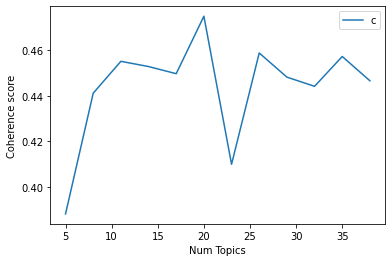

In [30]:
# 정수 인코딩과 빈도수 생성 
dictionary = corpora.Dictionary(book_train_nouns) 
# 출현빈도가 적거나 자주 등장하는 단어는 제거 
dictionary.filter_extremes(no_below=10, no_above=0.05) 
corpus = [dictionary.doc2bow(text) for text in book_train_nouns]
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus)) 
     
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 
     
# 최적의 토픽 수 찾기 
find_optimal_number_of_topics(dictionary, corpus, book_train_nouns)


In [40]:
from IPython.display import Image

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


![nn](img/최적토픽테스트_start5_step3_max38_필터링O.png)

----

#### 출현빈도가 적거나 자주 등장하는 단어는 제거X -> 걍 가지고 감

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-03-26 16:31:21,160 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-03-26 16:31:21,903 : INFO : adding document #10000 to Dictionary(28700 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 16:31:22,656 : INFO : adding document #20000 to Dictionary(38684 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 16:31:23,408 : INFO : adding document #30000 to Dictionary(45161 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 16:31:24,209 : INFO : adding document #40000 to Dictionary(51442 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 16:31:24,407

Number of unique tokens: 52744
Number of documents: 42337


2021-03-26 16:31:27,198 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:31:27,226 : INFO : topic #0 (0.200): 0.013*"생각" + 0.012*"아이" + 0.010*"내용" + 0.009*"사람" + 0.008*"이야기" + 0.008*"소설" + 0.007*"작가" + 0.007*"그림" + 0.006*"우리" + 0.006*"마음"
2021-03-26 16:31:27,227 : INFO : topic #1 (0.200): 0.015*"이야기" + 0.012*"생각" + 0.009*"소설" + 0.008*"내용" + 0.008*"작가" + 0.006*"사람" + 0.006*"삶" + 0.005*"작품" + 0.005*"번역" + 0.005*"말"
2021-03-26 16:31:27,228 : INFO : topic #2 (0.200): 0.014*"아이" + 0.013*"작가" + 0.010*"생각" + 0.008*"소설" + 0.008*"말" + 0.007*"사람" + 0.006*"이야기" + 0.006*"내용" + 0.006*"알다" + 0.005*"아빠"
2021-03-26 16:31:27,229 : INFO : topic #3 (0.200): 0.010*"생각" + 0.008*"아이" + 0.007*"이야기" + 0.006*"소설" + 0.006*"사람" + 0.006*"작가" + 0.006*"기대" + 0.006*"엄마" + 0.005*"보고" + 0.005*"다른"
2021-03-26 16:31:27,230 : INFO : topic #4 (0.200): 0.009*"사람" + 0.008*"이야기" + 0.008*"생각" + 0.007*"그림" + 0.006*"내용" + 0.006*"알다" + 0.005*"아이" + 0.005*"마음" + 0.005*"작가" + 0.005*"말"
202

2021-03-26 16:31:34,284 : INFO : topic #1 (0.200): 0.013*"이야기" + 0.013*"생각" + 0.012*"작가" + 0.012*"소설" + 0.010*"사람" + 0.008*"작품" + 0.007*"말" + 0.007*"글" + 0.007*"삶" + 0.007*"번역"
2021-03-26 16:31:34,285 : INFO : topic #2 (0.200): 0.013*"아이" + 0.010*"공부" + 0.010*"문제" + 0.008*"생각" + 0.008*"구매" + 0.007*"내용" + 0.006*"추천" + 0.006*"집" + 0.006*"교재" + 0.006*"영어"
2021-03-26 16:31:34,286 : INFO : topic #3 (0.200): 0.010*"기대" + 0.009*"시리즈" + 0.008*"작품" + 0.007*"생각" + 0.006*"가시" + 0.006*"소설" + 0.006*"재미" + 0.006*"보고" + 0.005*"게이고" + 0.005*"추리소설"
2021-03-26 16:31:34,287 : INFO : topic #4 (0.200): 0.012*"공부" + 0.012*"도움" + 0.011*"내용" + 0.011*"알다" + 0.010*"생각" + 0.010*"설명" + 0.009*"이해" + 0.009*"역사" + 0.007*"사람" + 0.005*"정리"
2021-03-26 16:31:34,289 : INFO : topic diff=0.288687, rho=0.353553
2021-03-26 16:31:34,290 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:31:35,115 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:31:35,129 : INFO : topic 

2021-03-26 16:31:41,055 : INFO : topic #2 (0.200): 0.023*"공부" + 0.018*"문제" + 0.012*"영어" + 0.011*"교재" + 0.010*"아이" + 0.010*"연산" + 0.008*"도움" + 0.007*"구성" + 0.007*"개념" + 0.007*"내용"
2021-03-26 16:31:41,056 : INFO : topic #3 (0.200): 0.012*"기대" + 0.011*"작품" + 0.009*"여행" + 0.008*"시리즈" + 0.007*"보고" + 0.006*"요리" + 0.006*"재미" + 0.006*"구매" + 0.005*"생각" + 0.005*"중"
2021-03-26 16:31:41,057 : INFO : topic #4 (0.200): 0.013*"내용" + 0.011*"생각" + 0.011*"도움" + 0.011*"역사" + 0.011*"설명" + 0.011*"알다" + 0.010*"이해" + 0.008*"사람" + 0.007*"공부" + 0.007*"저자"
2021-03-26 16:31:41,059 : INFO : topic diff=0.191413, rho=0.258199
2021-03-26 16:31:41,060 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:31:41,773 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:31:41,788 : INFO : topic #0 (0.200): 0.039*"아이" + 0.022*"그림" + 0.014*"마음" + 0.012*"생각" + 0.010*"내용" + 0.009*"이야기" + 0.009*"엄마" + 0.008*"선물" + 0.007*"우리" + 0.007*"구매"
2021-03-26 16:31:41,789 : INFO : topic 

2021-03-26 16:31:47,088 : INFO : topic #2 (0.200): 0.027*"공부" + 0.018*"영어" + 0.013*"문제" + 0.010*"도움" + 0.010*"교재" + 0.009*"아이" + 0.008*"설명" + 0.008*"단어" + 0.007*"내용" + 0.007*"학습"
2021-03-26 16:31:47,089 : INFO : topic #3 (0.200): 0.014*"기대" + 0.013*"작품" + 0.011*"여행" + 0.009*"시리즈" + 0.008*"보고" + 0.008*"소설" + 0.007*"구매" + 0.006*"재미" + 0.005*"요리" + 0.005*"느낌"
2021-03-26 16:31:47,090 : INFO : topic #4 (0.200): 0.013*"내용" + 0.012*"생각" + 0.011*"알다" + 0.011*"역사" + 0.011*"도움" + 0.011*"이해" + 0.010*"설명" + 0.008*"사람" + 0.007*"저자" + 0.006*"통해"
2021-03-26 16:31:47,091 : INFO : topic diff=0.162141, rho=0.213201
2021-03-26 16:31:47,095 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:31:53,766 : INFO : 14 batches submitted to accumulate stats from 896 documents (-35538 virtual)
2021-03-26 16:31:53,770 : INFO : 15 batches submitted to accumulate stats from 960 documents (-35462 virtual)
2021-03-26 16:31:53,776 : 

num_topics :  5


2021-03-26 16:32:05,466 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:32:05,489 : INFO : topic #5 (0.125): 0.015*"생각" + 0.010*"작가" + 0.010*"이야기" + 0.008*"아이" + 0.007*"사람" + 0.007*"내용" + 0.007*"우리" + 0.006*"삶" + 0.006*"마음" + 0.006*"기대"
2021-03-26 16:32:05,490 : INFO : topic #6 (0.125): 0.009*"소설" + 0.008*"작가" + 0.008*"내용" + 0.007*"생각" + 0.006*"그림" + 0.006*"사람" + 0.006*"이야기" + 0.006*"공부" + 0.006*"마음" + 0.006*"보고"
2021-03-26 16:32:05,491 : INFO : topic #7 (0.125): 0.011*"아이" + 0.011*"작품" + 0.010*"생각" + 0.009*"작가" + 0.008*"이야기" + 0.007*"말" + 0.007*"소설" + 0.006*"내용" + 0.005*"기대" + 0.005*"번역"
2021-03-26 16:32:05,492 : INFO : topic #3 (0.125): 0.010*"생각" + 0.008*"작가" + 0.008*"이야기" + 0.007*"소설" + 0.007*"내용" + 0.006*"그림" + 0.006*"아이" + 0.006*"알다" + 0.006*"사람" + 0.006*"마음"
2021-03-26 16:32:05,493 : INFO : topic #1 (0.125): 0.019*"아이" + 0.014*"생각" + 0.010*"이야기" + 0.006*"작가" + 0.006*"엄마" + 0.006*"소설" + 0.006*"아빠" + 0.006*"말" + 0.005*"마음" + 0.005*"중"
202

2021-03-26 16:32:12,393 : INFO : topic #6 (0.125): 0.032*"공부" + 0.014*"도움" + 0.013*"문제" + 0.011*"영어" + 0.011*"단어" + 0.010*"교재" + 0.009*"설명" + 0.008*"집" + 0.008*"추천" + 0.008*"내용"
2021-03-26 16:32:12,394 : INFO : topic #2 (0.125): 0.016*"사람" + 0.016*"생각" + 0.013*"작가" + 0.013*"말" + 0.012*"글" + 0.010*"소설" + 0.008*"이야기" + 0.007*"내용" + 0.006*"문장" + 0.006*"사랑"
2021-03-26 16:32:12,395 : INFO : topic #1 (0.125): 0.062*"아이" + 0.015*"엄마" + 0.013*"생각" + 0.012*"그림" + 0.009*"이야기" + 0.009*"마음" + 0.009*"어른" + 0.008*"우리" + 0.008*"요리" + 0.007*"내용"
2021-03-26 16:32:12,396 : INFO : topic #7 (0.125): 0.020*"작품" + 0.015*"소설" + 0.013*"작가" + 0.010*"번역" + 0.009*"기대" + 0.008*"이야기" + 0.007*"시리즈" + 0.006*"중" + 0.006*"생각" + 0.006*"구매"
2021-03-26 16:32:12,398 : INFO : topic diff=0.179667, rho=0.353553
2021-03-26 16:32:12,399 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:32:13,239 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:32:13,263 : INFO : topic #

2021-03-26 16:32:19,394 : INFO : topic #1 (0.125): 0.078*"아이" + 0.018*"엄마" + 0.016*"그림" + 0.011*"생각" + 0.009*"내용" + 0.008*"우리" + 0.008*"어른" + 0.008*"그림책" + 0.008*"마음" + 0.008*"요리"
2021-03-26 16:32:19,395 : INFO : topic #3 (0.125): 0.022*"그림" + 0.018*"만화" + 0.009*"내용" + 0.009*"생각" + 0.006*"디자인" + 0.006*"보고" + 0.005*"하나" + 0.005*"알다" + 0.005*"사람" + 0.005*"설명"
2021-03-26 16:32:19,396 : INFO : topic #5 (0.125): 0.019*"생각" + 0.013*"우리" + 0.013*"삶" + 0.013*"사람" + 0.012*"마음" + 0.012*"이야기" + 0.007*"말" + 0.007*"일" + 0.006*"인생" + 0.006*"다시"
2021-03-26 16:32:19,399 : INFO : topic diff=0.108998, rho=0.258199
2021-03-26 16:32:19,400 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:32:20,127 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:32:20,150 : INFO : topic #2 (0.125): 0.018*"사람" + 0.017*"생각" + 0.015*"글" + 0.014*"말" + 0.012*"작가" + 0.008*"내용" + 0.007*"이야기" + 0.007*"문장" + 0.006*"사랑" + 0.006*"자신"
2021-03-26 16:32:20,151 : INFO : topic #7

2021-03-26 16:32:25,641 : INFO : topic #1 (0.125): 0.086*"아이" + 0.017*"엄마" + 0.015*"그림" + 0.011*"어른" + 0.011*"생각" + 0.010*"우리" + 0.010*"그림책" + 0.009*"아들" + 0.008*"요리" + 0.008*"내용"
2021-03-26 16:32:25,642 : INFO : topic #5 (0.125): 0.022*"생각" + 0.015*"이야기" + 0.015*"삶" + 0.014*"우리" + 0.013*"사람" + 0.012*"마음" + 0.008*"여성" + 0.008*"사회" + 0.007*"일" + 0.007*"세상"
2021-03-26 16:32:25,643 : INFO : topic #6 (0.125): 0.037*"공부" + 0.022*"영어" + 0.015*"문제" + 0.015*"도움" + 0.012*"교재" + 0.011*"설명" + 0.010*"단어" + 0.008*"학습" + 0.008*"수학" + 0.008*"구성"
2021-03-26 16:32:25,646 : INFO : topic diff=0.111900, rho=0.213201
2021-03-26 16:32:25,652 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:32:32,199 : INFO : 12 batches submitted to accumulate stats from 768 documents (-34687 virtual)
2021-03-26 16:32:32,218 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-35866 virtual)
2021-03-26 16:32:32,466 : 

num_topics :  8


2021-03-26 16:32:46,848 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:32:46,880 : INFO : topic #3 (0.091): 0.009*"작가" + 0.009*"말" + 0.009*"생각" + 0.008*"작품" + 0.008*"공부" + 0.007*"번역" + 0.006*"설명" + 0.006*"사람" + 0.005*"그림" + 0.005*"알다"
2021-03-26 16:32:46,881 : INFO : topic #4 (0.091): 0.026*"아이" + 0.011*"이야기" + 0.010*"말" + 0.008*"기대" + 0.007*"작가" + 0.007*"생각" + 0.007*"내용" + 0.006*"우리" + 0.006*"그림" + 0.006*"엄마"
2021-03-26 16:32:46,882 : INFO : topic #2 (0.091): 0.012*"아이" + 0.011*"소설" + 0.011*"이야기" + 0.009*"작가" + 0.007*"생각" + 0.007*"작품" + 0.005*"사람" + 0.005*"알다" + 0.005*"보고" + 0.004*"그림"
2021-03-26 16:32:46,883 : INFO : topic #0 (0.091): 0.013*"사람" + 0.010*"생각" + 0.010*"이야기" + 0.009*"내용" + 0.008*"작가" + 0.007*"소설" + 0.006*"글" + 0.005*"알다" + 0.005*"다른" + 0.005*"말"
2021-03-26 16:32:46,884 : INFO : topic #8 (0.091): 0.012*"생각" + 0.009*"사람" + 0.009*"작가" + 0.007*"내용" + 0.007*"이야기" + 0.006*"도서관" + 0.006*"소설" + 0.005*"기대" + 0.005*"저자" + 0.005*"말"
2021

2021-03-26 16:32:53,664 : INFO : topic #3 (0.091): 0.033*"공부" + 0.014*"문제" + 0.014*"설명" + 0.014*"도움" + 0.012*"영어" + 0.012*"단어" + 0.010*"교재" + 0.009*"추천" + 0.009*"내용" + 0.008*"구성"
2021-03-26 16:32:53,665 : INFO : topic #2 (0.091): 0.021*"소설" + 0.019*"작품" + 0.013*"작가" + 0.012*"이야기" + 0.011*"기대" + 0.011*"영화" + 0.008*"시리즈" + 0.008*"재미" + 0.007*"주인공" + 0.007*"느낌"
2021-03-26 16:32:53,666 : INFO : topic #7 (0.091): 0.023*"번역" + 0.015*"구매" + 0.011*"표지" + 0.009*"작품" + 0.007*"작가" + 0.006*"출판사" + 0.006*"내용" + 0.006*"하나" + 0.006*"중" + 0.006*"소설"
2021-03-26 16:32:53,667 : INFO : topic #10 (0.091): 0.013*"구매" + 0.010*"내용" + 0.010*"주식" + 0.010*"생각" + 0.009*"이벤트" + 0.008*"좀비" + 0.008*"기대" + 0.008*"다이어리" + 0.007*"알다" + 0.007*"투자"
2021-03-26 16:32:53,670 : INFO : topic diff=0.134628, rho=0.353553
2021-03-26 16:32:53,671 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:32:54,466 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:32:54,498 : INFO : 

2021-03-26 16:33:00,402 : INFO : topic #7 (0.091): 0.030*"번역" + 0.018*"구매" + 0.010*"내용" + 0.009*"표지" + 0.007*"출판사" + 0.007*"디자인" + 0.007*"소장" + 0.006*"중" + 0.006*"구입" + 0.005*"거"
2021-03-26 16:33:00,404 : INFO : topic #10 (0.091): 0.026*"운동" + 0.018*"투자" + 0.014*"부자" + 0.014*"주식" + 0.013*"약" + 0.010*"기대" + 0.010*"구매" + 0.010*"유튜브" + 0.009*"다이어트" + 0.009*"의사"
2021-03-26 16:33:00,405 : INFO : topic #9 (0.091): 0.035*"만화" + 0.030*"신화" + 0.022*"그리스" + 0.018*"로마" + 0.015*"박스" + 0.009*"세트" + 0.007*"개정판" + 0.006*"이야기" + 0.006*"생각" + 0.006*"내용"
2021-03-26 16:33:00,408 : INFO : topic diff=0.071347, rho=0.258199
2021-03-26 16:33:00,409 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:33:01,107 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:33:01,141 : INFO : topic #3 (0.091): 0.037*"공부" + 0.022*"문제" + 0.015*"영어" + 0.015*"교재" + 0.014*"설명" + 0.012*"도움" + 0.011*"개념" + 0.010*"연산" + 0.010*"구성" + 0.009*"학습"
2021-03-26 16:33:01,142 : INFO : t

2021-03-26 16:33:06,519 : INFO : topic #7 (0.091): 0.032*"번역" + 0.018*"구매" + 0.011*"내용" + 0.008*"표지" + 0.007*"디자인" + 0.007*"출판사" + 0.007*"판" + 0.007*"구입" + 0.006*"소장" + 0.006*"거"
2021-03-26 16:33:06,520 : INFO : topic #1 (0.091): 0.020*"생각" + 0.017*"이야기" + 0.015*"사람" + 0.013*"작가" + 0.012*"삶" + 0.012*"마음" + 0.011*"말" + 0.011*"글" + 0.008*"공감" + 0.008*"우리"
2021-03-26 16:33:06,521 : INFO : topic #9 (0.091): 0.067*"만화" + 0.037*"그리스" + 0.019*"로마" + 0.018*"신화" + 0.013*"스페인" + 0.011*"박스" + 0.011*"스누피" + 0.010*"노부" + 0.008*"괴물" + 0.008*"세트"
2021-03-26 16:33:06,524 : INFO : topic diff=0.074919, rho=0.213201
2021-03-26 16:33:06,533 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:33:13,007 : INFO : 15 batches submitted to accumulate stats from 960 documents (-39606 virtual)
2021-03-26 16:33:13,014 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-39289 virtual)
2021-03-26 16:33:13,282 :

num_topics :  11


2021-03-26 16:33:31,221 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:33:31,262 : INFO : topic #8 (0.071): 0.015*"생각" + 0.009*"내용" + 0.008*"사람" + 0.007*"알다" + 0.007*"이야기" + 0.007*"삶" + 0.006*"추천" + 0.005*"말" + 0.005*"유통" + 0.005*"마음"
2021-03-26 16:33:31,263 : INFO : topic #13 (0.071): 0.013*"생각" + 0.013*"이야기" + 0.011*"작가" + 0.010*"사람" + 0.009*"소설" + 0.008*"마음" + 0.007*"아이" + 0.007*"작품" + 0.005*"삶" + 0.005*"우리"
2021-03-26 16:33:31,264 : INFO : topic #10 (0.071): 0.013*"작가" + 0.010*"내용" + 0.010*"소설" + 0.009*"생각" + 0.007*"작품" + 0.007*"그림" + 0.007*"이야기" + 0.006*"기대" + 0.005*"우리" + 0.005*"느낌"
2021-03-26 16:33:31,265 : INFO : topic #11 (0.071): 0.017*"생각" + 0.011*"이야기" + 0.010*"작가" + 0.009*"소설" + 0.008*"내용" + 0.008*"말" + 0.007*"사람" + 0.007*"작품" + 0.006*"여행" + 0.005*"기대"
2021-03-26 16:33:31,266 : INFO : topic #4 (0.071): 0.013*"생각" + 0.012*"작가" + 0.011*"이야기" + 0.008*"소설" + 0.008*"사람" + 0.008*"내용" + 0.007*"글" + 0.007*"공부" + 0.006*"기대" + 0.006*"말"
20

2021-03-26 16:33:38,352 : INFO : topic #2 (0.071): 0.036*"공부" + 0.017*"도움" + 0.015*"설명" + 0.015*"단어" + 0.014*"영어" + 0.009*"내용" + 0.009*"추천" + 0.009*"그림" + 0.008*"알다" + 0.008*"이해"
2021-03-26 16:33:38,353 : INFO : topic #10 (0.071): 0.014*"그림" + 0.013*"표지" + 0.012*"작가" + 0.009*"작품" + 0.009*"구매" + 0.008*"내용" + 0.008*"생각" + 0.007*"시" + 0.007*"마음" + 0.007*"기대"
2021-03-26 16:33:38,354 : INFO : topic #7 (0.071): 0.019*"번역" + 0.018*"고양이" + 0.011*"웹툰" + 0.011*"내용" + 0.008*"생각" + 0.007*"사진" + 0.006*"소장" + 0.005*"그림" + 0.005*"이해" + 0.005*"다시"
2021-03-26 16:33:38,355 : INFO : topic #0 (0.071): 0.044*"문제" + 0.020*"문" + 0.016*"교재" + 0.015*"개념" + 0.013*"시험" + 0.013*"풀다" + 0.012*"공부" + 0.011*"국어" + 0.010*"집" + 0.010*"도움"
2021-03-26 16:33:38,359 : INFO : topic diff=0.136141, rho=0.353553
2021-03-26 16:33:38,361 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:33:39,256 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:33:39,297 : INFO : topic #1

2021-03-26 16:33:45,779 : INFO : topic #1 (0.071): 0.044*"과학" + 0.018*"지문" + 0.013*"인간" + 0.012*"미술" + 0.010*"설명" + 0.010*"음악" + 0.009*"곡" + 0.009*"이야기" + 0.008*"동물" + 0.008*"우주"
2021-03-26 16:33:45,780 : INFO : topic #11 (0.071): 0.012*"작가" + 0.012*"소설" + 0.012*"여행" + 0.012*"생각" + 0.011*"작품" + 0.010*"이야기" + 0.007*"번역" + 0.006*"말" + 0.006*"사람" + 0.006*"기대"
2021-03-26 16:33:45,781 : INFO : topic #2 (0.071): 0.043*"공부" + 0.021*"영어" + 0.018*"설명" + 0.017*"도움" + 0.014*"단어" + 0.010*"내용" + 0.010*"기초" + 0.010*"추천" + 0.009*"구성" + 0.009*"교재"
2021-03-26 16:33:45,785 : INFO : topic diff=0.077494, rho=0.258199
2021-03-26 16:33:45,786 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:33:46,565 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:33:46,606 : INFO : topic #11 (0.071): 0.014*"여행" + 0.013*"소설" + 0.013*"작가" + 0.012*"작품" + 0.011*"생각" + 0.010*"이야기" + 0.006*"번역" + 0.006*"말" + 0.006*"사람" + 0.006*"영화"
2021-03-26 16:33:46,607 : INFO : topic

2021-03-26 16:33:52,612 : INFO : topic #13 (0.071): 0.026*"이야기" + 0.019*"생각" + 0.018*"작가" + 0.017*"마음" + 0.016*"사람" + 0.014*"삶" + 0.013*"사랑" + 0.012*"소설" + 0.010*"공감" + 0.009*"글"
2021-03-26 16:33:52,613 : INFO : topic #0 (0.071): 0.069*"문제" + 0.027*"수학" + 0.022*"피아노" + 0.021*"개념" + 0.020*"문" + 0.019*"교재" + 0.019*"시험" + 0.018*"풀다" + 0.016*"집" + 0.015*"공부"
2021-03-26 16:33:52,614 : INFO : topic #8 (0.071): 0.024*"생각" + 0.014*"사람" + 0.013*"알다" + 0.010*"내용" + 0.010*"도움" + 0.009*"이해" + 0.009*"통해" + 0.008*"삶" + 0.008*"고전" + 0.007*"우리"
2021-03-26 16:33:52,618 : INFO : topic diff=0.074557, rho=0.213201
2021-03-26 16:33:52,628 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:33:59,175 : INFO : 15 batches submitted to accumulate stats from 960 documents (-39715 virtual)
2021-03-26 16:33:59,181 : INFO : 16 batches submitted to accumulate stats from 1024 documents (-39296 virtual)
2021-03-26 16:33:59,552 : IN

num_topics :  14


2021-03-26 16:34:17,291 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:34:17,340 : INFO : topic #9 (0.059): 0.013*"이야기" + 0.011*"작가" + 0.008*"기대" + 0.008*"생각" + 0.008*"작품" + 0.006*"내용" + 0.006*"사람" + 0.006*"아이" + 0.006*"소설" + 0.006*"마음"
2021-03-26 16:34:17,341 : INFO : topic #2 (0.059): 0.017*"아이" + 0.014*"생각" + 0.009*"작가" + 0.008*"이야기" + 0.008*"사람" + 0.007*"마음" + 0.007*"아빠" + 0.007*"글" + 0.007*"시간" + 0.007*"말"
2021-03-26 16:34:17,342 : INFO : topic #12 (0.059): 0.013*"생각" + 0.009*"내용" + 0.008*"그림" + 0.008*"이야기" + 0.008*"소설" + 0.007*"말" + 0.007*"번역" + 0.006*"마음" + 0.006*"사람" + 0.005*"작가"
2021-03-26 16:34:17,343 : INFO : topic #16 (0.059): 0.013*"아이" + 0.010*"생각" + 0.010*"내용" + 0.009*"작가" + 0.008*"소설" + 0.006*"사람" + 0.006*"이야기" + 0.006*"작품" + 0.005*"공부" + 0.005*"알다"
2021-03-26 16:34:17,344 : INFO : topic #1 (0.059): 0.012*"작가" + 0.008*"글" + 0.007*"아이" + 0.007*"사람" + 0.007*"이야기" + 0.007*"그림" + 0.006*"생각" + 0.005*"공부" + 0.005*"작품" + 0.005*"표지"
2

2021-03-26 16:34:24,687 : INFO : topic #10 (0.059): 0.025*"생각" + 0.019*"사람" + 0.013*"말" + 0.010*"삶" + 0.010*"철학" + 0.009*"알다" + 0.009*"저자" + 0.009*"내용" + 0.007*"자신" + 0.007*"글"
2021-03-26 16:34:24,688 : INFO : topic #11 (0.059): 0.048*"공부" + 0.031*"아이" + 0.019*"도움" + 0.017*"문제" + 0.013*"교재" + 0.013*"수학" + 0.012*"추천" + 0.011*"개념" + 0.011*"정리" + 0.011*"학습"
2021-03-26 16:34:24,689 : INFO : topic #2 (0.059): 0.026*"아이" + 0.021*"마음" + 0.019*"생각" + 0.012*"사람" + 0.011*"이야기" + 0.011*"글" + 0.010*"우리" + 0.009*"엄마" + 0.009*"삶" + 0.009*"말"
2021-03-26 16:34:24,690 : INFO : topic #5 (0.059): 0.028*"소설" + 0.021*"작가" + 0.020*"이야기" + 0.017*"작품" + 0.010*"생각" + 0.009*"영화" + 0.007*"기대" + 0.007*"느낌" + 0.006*"사람" + 0.006*"주인공"
2021-03-26 16:34:24,694 : INFO : topic diff=0.162327, rho=0.353553
2021-03-26 16:34:24,696 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:34:25,563 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:34:25,613 : INFO : topic #2

2021-03-26 16:34:32,186 : INFO : topic #14 (0.059): 0.039*"만화" + 0.018*"구매" + 0.017*"그림" + 0.014*"보고" + 0.011*"소장" + 0.011*"작품" + 0.011*"내용" + 0.011*"기대" + 0.010*"진짜" + 0.007*"재미"
2021-03-26 16:34:32,187 : INFO : topic #2 (0.059): 0.034*"아이" + 0.022*"마음" + 0.017*"생각" + 0.012*"이야기" + 0.011*"그림" + 0.011*"우리" + 0.011*"엄마" + 0.010*"사람" + 0.010*"글" + 0.008*"작가"
2021-03-26 16:34:32,189 : INFO : topic #5 (0.059): 0.026*"소설" + 0.024*"작가" + 0.022*"이야기" + 0.019*"작품" + 0.010*"생각" + 0.009*"영화" + 0.008*"기대" + 0.007*"사랑" + 0.007*"느낌" + 0.006*"사람"
2021-03-26 16:34:32,193 : INFO : topic diff=0.086808, rho=0.258199
2021-03-26 16:34:32,195 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:34:32,949 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:34:32,999 : INFO : topic #8 (0.059): 0.021*"전쟁" + 0.018*"층" + 0.015*"건축" + 0.014*"혁명" + 0.012*"신" + 0.010*"프랑스" + 0.009*"역사" + 0.007*"주의" + 0.006*"인간" + 0.006*"교회"
2021-03-26 16:34:33,001 : INFO : topic 

2021-03-26 16:34:39,020 : INFO : topic #0 (0.059): 0.045*"과학" + 0.020*"요리" + 0.014*"인류" + 0.013*"음식" + 0.012*"레시피" + 0.012*"중국" + 0.012*"이야기" + 0.011*"인간" + 0.011*"우주" + 0.010*"생각"
2021-03-26 16:34:39,021 : INFO : topic #16 (0.059): 0.014*"유형" + 0.014*"구매" + 0.013*"문제" + 0.010*"아이" + 0.010*"집" + 0.010*"배송" + 0.010*"내용" + 0.009*"연습" + 0.008*"구성" + 0.008*"풀이"
2021-03-26 16:34:39,022 : INFO : topic #15 (0.059): 0.086*"영어" + 0.043*"공부" + 0.042*"단어" + 0.021*"한글" + 0.016*"그리스" + 0.013*"문장" + 0.012*"한자" + 0.010*"표현" + 0.010*"회화" + 0.009*"시작"
2021-03-26 16:34:39,026 : INFO : topic diff=0.091775, rho=0.213201
2021-03-26 16:34:39,039 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:34:46,394 : INFO : 53 batches submitted to accumulate stats from 3392 documents (-131972 virtual)
2021-03-26 16:34:46,622 : INFO : 63 batches submitted to accumulate stats from 4032 documents (-147813 virtual)
2021-03-26 16:34:46

num_topics :  17


2021-03-26 16:35:09,423 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:35:09,481 : INFO : topic #2 (0.050): 0.013*"생각" + 0.010*"이야기" + 0.010*"작가" + 0.006*"보고" + 0.006*"문제" + 0.006*"다른" + 0.006*"사람" + 0.005*"저자" + 0.005*"내용" + 0.005*"소설"
2021-03-26 16:35:09,482 : INFO : topic #6 (0.050): 0.009*"사람" + 0.009*"작가" + 0.009*"생각" + 0.007*"이야기" + 0.006*"내용" + 0.005*"글" + 0.005*"소설" + 0.004*"공부" + 0.004*"다시" + 0.004*"기대"
2021-03-26 16:35:09,483 : INFO : topic #7 (0.050): 0.013*"생각" + 0.011*"아이" + 0.011*"이야기" + 0.009*"그림" + 0.007*"사람" + 0.007*"경주" + 0.007*"마음" + 0.007*"기대" + 0.007*"작가" + 0.005*"알다"
2021-03-26 16:35:09,484 : INFO : topic #19 (0.050): 0.011*"이야기" + 0.011*"작가" + 0.009*"사람" + 0.009*"소설" + 0.009*"아이" + 0.008*"생각" + 0.008*"작품" + 0.007*"말" + 0.005*"이해" + 0.005*"마음"
2021-03-26 16:35:09,485 : INFO : topic #18 (0.050): 0.010*"생각" + 0.009*"아이" + 0.007*"작가" + 0.006*"보고" + 0.006*"도움" + 0.006*"말" + 0.006*"거" + 0.005*"설명" + 0.005*"글" + 0.005*"문장"
202

2021-03-26 16:35:16,879 : INFO : topic #19 (0.050): 0.012*"커피" + 0.010*"고전" + 0.009*"사람" + 0.008*"현상학" + 0.008*"이벤트" + 0.007*"후설" + 0.007*"이야기" + 0.006*"생각" + 0.005*"알다" + 0.005*"말"
2021-03-26 16:35:16,880 : INFO : topic #17 (0.050): 0.030*"소설" + 0.023*"작가" + 0.020*"작품" + 0.016*"이야기" + 0.010*"생각" + 0.009*"영화" + 0.007*"느낌" + 0.006*"사람" + 0.006*"주인공" + 0.006*"인간"
2021-03-26 16:35:16,882 : INFO : topic #15 (0.050): 0.075*"번역" + 0.027*"표지" + 0.021*"디자인" + 0.019*"집" + 0.016*"카드" + 0.011*"출판사" + 0.010*"가격" + 0.009*"판" + 0.008*"구매" + 0.007*"구입"
2021-03-26 16:35:16,883 : INFO : topic #12 (0.050): 0.019*"킹" + 0.013*"음악" + 0.013*"패션" + 0.013*"부자" + 0.012*"돈" + 0.011*"사람" + 0.009*"생각" + 0.009*"세계사" + 0.009*"기대" + 0.007*"내용"
2021-03-26 16:35:16,888 : INFO : topic diff=0.179222, rho=0.353553
2021-03-26 16:35:16,890 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:35:17,782 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:35:17,841 : INFO : 

2021-03-26 16:35:24,497 : INFO : topic #7 (0.050): 0.045*"그림" + 0.039*"여행" + 0.027*"사진" + 0.027*"고양이" + 0.011*"생각" + 0.011*"미술" + 0.010*"동물" + 0.010*"마음" + 0.009*"이야기" + 0.009*"기대"
2021-03-26 16:35:24,498 : INFO : topic #3 (0.050): 0.021*"구매" + 0.019*"한국사" + 0.012*"내용" + 0.009*"구입" + 0.008*"쌤" + 0.008*"정발" + 0.007*"초판" + 0.006*"이번" + 0.006*"생각" + 0.006*"비즈니스"
2021-03-26 16:35:24,499 : INFO : topic #16 (0.050): 0.040*"그림" + 0.039*"만화" + 0.031*"구매" + 0.015*"보고" + 0.014*"소장" + 0.013*"기대" + 0.011*"내용" + 0.010*"배송" + 0.010*"주문" + 0.008*"체"
2021-03-26 16:35:24,504 : INFO : topic diff=0.091048, rho=0.258199
2021-03-26 16:35:24,506 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:35:25,282 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:35:25,341 : INFO : topic #17 (0.050): 0.029*"소설" + 0.027*"작가" + 0.022*"작품" + 0.019*"이야기" + 0.011*"영화" + 0.009*"생각" + 0.007*"느낌" + 0.007*"기대" + 0.006*"인간" + 0.006*"주인공"
2021-03-26 16:35:25,342 : INFO : 

2021-03-26 16:35:31,605 : INFO : topic #19 (0.050): 0.097*"고전" + 0.011*"대통령" + 0.008*"운" + 0.007*"사람" + 0.007*"명" + 0.007*"커피" + 0.006*"프랑스" + 0.006*"양" + 0.005*"전집" + 0.005*"삼국지"
2021-03-26 16:35:31,606 : INFO : topic #1 (0.050): 0.052*"혐오" + 0.046*"여성" + 0.016*"우주" + 0.011*"남성" + 0.011*"페미니즘" + 0.011*"지구" + 0.010*"남자" + 0.009*"문제" + 0.008*"차별" + 0.008*"여자"
2021-03-26 16:35:31,607 : INFO : topic #13 (0.050): 0.137*"아이" + 0.023*"엄마" + 0.014*"어른" + 0.014*"그림" + 0.014*"아들" + 0.013*"수학" + 0.012*"학년" + 0.012*"그림책" + 0.012*"우리" + 0.009*"생각"
2021-03-26 16:35:31,612 : INFO : topic diff=0.091724, rho=0.213201
2021-03-26 16:35:31,627 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:35:38,678 : INFO : 38 batches submitted to accumulate stats from 2432 documents (-96682 virtual)
2021-03-26 16:35:39,069 : INFO : 52 batches submitted to accumulate stats from 3328 documents (-134261 virtual)
2021-03-26 16:35:39

num_topics :  20


2021-03-26 16:36:05,280 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:36:05,346 : INFO : topic #0 (0.043): 0.012*"생각" + 0.008*"이야기" + 0.007*"내용" + 0.006*"삶" + 0.006*"과학" + 0.006*"사람" + 0.006*"문장" + 0.005*"공부" + 0.005*"작품" + 0.005*"기대"
2021-03-26 16:36:05,348 : INFO : topic #1 (0.043): 0.019*"이야기" + 0.011*"생각" + 0.010*"작가" + 0.009*"내용" + 0.008*"사람" + 0.008*"소설" + 0.007*"번역" + 0.006*"사랑" + 0.006*"속" + 0.005*"기대"
2021-03-26 16:36:05,349 : INFO : topic #11 (0.043): 0.019*"아이" + 0.011*"그림" + 0.010*"생각" + 0.009*"말" + 0.007*"구매" + 0.006*"작가" + 0.006*"아빠" + 0.006*"도움" + 0.005*"마음" + 0.005*"내용"
2021-03-26 16:36:05,350 : INFO : topic #20 (0.043): 0.037*"아이" + 0.015*"생각" + 0.014*"공부" + 0.013*"엄마" + 0.012*"내용" + 0.007*"마음" + 0.007*"이야기" + 0.006*"우리" + 0.006*"그림" + 0.005*"말"
2021-03-26 16:36:05,351 : INFO : topic #2 (0.043): 0.010*"생각" + 0.009*"삶" + 0.008*"이야기" + 0.007*"그림" + 0.007*"내용" + 0.007*"사람" + 0.006*"죽음" + 0.005*"한자" + 0.005*"우리" + 0.005*"이해"
202

2021-03-26 16:36:13,263 : INFO : topic #20 (0.043): 0.078*"아이" + 0.017*"엄마" + 0.015*"공부" + 0.013*"생각" + 0.011*"도움" + 0.010*"내용" + 0.009*"마음" + 0.009*"학년" + 0.009*"어른" + 0.009*"그림"
2021-03-26 16:36:13,265 : INFO : topic #9 (0.043): 0.014*"기대" + 0.014*"작품" + 0.013*"시리즈" + 0.012*"만화" + 0.011*"작가" + 0.010*"구매" + 0.010*"가시" + 0.010*"재미" + 0.009*"게이고" + 0.009*"소설"
2021-03-26 16:36:13,266 : INFO : topic #12 (0.043): 0.019*"중국" + 0.016*"일본" + 0.013*"세계사" + 0.012*"전쟁" + 0.010*"경제" + 0.010*"생각" + 0.009*"알다" + 0.009*"뇌" + 0.008*"역사" + 0.007*"이야기"
2021-03-26 16:36:13,267 : INFO : topic #17 (0.043): 0.012*"분석" + 0.011*"기술" + 0.010*"생각" + 0.010*"내용" + 0.009*"청소년" + 0.009*"조선" + 0.009*"시대" + 0.008*"등" + 0.008*"알다" + 0.006*"관심"
2021-03-26 16:36:13,273 : INFO : topic diff=0.196090, rho=0.353553
2021-03-26 16:36:13,275 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:36:14,170 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:36:14,238 : INFO : t

2021-03-26 16:36:21,118 : INFO : topic #15 (0.043): 0.024*"운동" + 0.020*"투자" + 0.017*"알다" + 0.017*"건강" + 0.016*"도움" + 0.013*"정보" + 0.013*"약" + 0.011*"추천" + 0.010*"주식" + 0.009*"다이어트"
2021-03-26 16:36:21,120 : INFO : topic #7 (0.043): 0.046*"여행" + 0.032*"사진" + 0.022*"마음" + 0.018*"글" + 0.016*"집" + 0.013*"생각" + 0.011*"곳" + 0.011*"기대" + 0.009*"에세이" + 0.008*"그림"
2021-03-26 16:36:21,120 : INFO : topic #14 (0.043): 0.043*"구매" + 0.021*"기대" + 0.019*"보고" + 0.017*"배송" + 0.016*"주문" + 0.015*"구입" + 0.013*"바로" + 0.012*"선물" + 0.010*"이번" + 0.010*"소장"
2021-03-26 16:36:21,126 : INFO : topic diff=0.095723, rho=0.258199
2021-03-26 16:36:21,128 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:36:21,934 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:36:22,003 : INFO : topic #4 (0.043): 0.025*"생각" + 0.024*"사람" + 0.021*"말" + 0.017*"도움" + 0.017*"내용" + 0.016*"방법" + 0.014*"고양이" + 0.013*"알다" + 0.012*"돈" + 0.011*"글쓰기"
2021-03-26 16:36:22,004 : INFO : topic 

2021-03-26 16:36:28,576 : INFO : topic #0 (0.043): 0.069*"공부" + 0.050*"영어" + 0.033*"문제" + 0.023*"교재" + 0.022*"단어" + 0.017*"도움" + 0.015*"학습" + 0.014*"정리" + 0.014*"개념" + 0.013*"구성"
2021-03-26 16:36:28,577 : INFO : topic #15 (0.043): 0.024*"투자" + 0.024*"운동" + 0.019*"도움" + 0.017*"알다" + 0.017*"정보" + 0.015*"주식" + 0.014*"건강" + 0.013*"약" + 0.013*"몸" + 0.011*"법"
2021-03-26 16:36:28,578 : INFO : topic #8 (0.043): 0.070*"영화" + 0.042*"시" + 0.026*"드라마" + 0.024*"그리스" + 0.022*"시집" + 0.022*"시인" + 0.013*"다시" + 0.012*"원작" + 0.012*"보고" + 0.012*"로마"
2021-03-26 16:36:28,584 : INFO : topic diff=0.082263, rho=0.213201
2021-03-26 16:36:28,599 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:36:35,112 : INFO : 17 batches submitted to accumulate stats from 1088 documents (-41465 virtual)
2021-03-26 16:36:35,674 : INFO : 38 batches submitted to accumulate stats from 2432 documents (-96890 virtual)
2021-03-26 16:36:36,163 : 

num_topics :  23


2021-03-26 16:37:05,427 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:37:05,501 : INFO : topic #4 (0.038): 0.016*"생각" + 0.009*"그림" + 0.009*"내용" + 0.007*"구매" + 0.006*"삶" + 0.006*"아이" + 0.006*"사람" + 0.005*"사랑" + 0.005*"작가" + 0.005*"공부"
2021-03-26 16:37:05,503 : INFO : topic #24 (0.038): 0.010*"생각" + 0.010*"내용" + 0.009*"사람" + 0.007*"작가" + 0.007*"추천" + 0.006*"이야기" + 0.006*"알다" + 0.006*"아이" + 0.005*"저자" + 0.005*"말"
2021-03-26 16:37:05,503 : INFO : topic #14 (0.038): 0.018*"작가" + 0.011*"소설" + 0.010*"생각" + 0.008*"사람" + 0.008*"이야기" + 0.006*"내용" + 0.006*"보고" + 0.005*"이번" + 0.004*"마음" + 0.004*"작품"
2021-03-26 16:37:05,505 : INFO : topic #8 (0.038): 0.011*"생각" + 0.010*"사람" + 0.009*"아이" + 0.007*"내용" + 0.007*"그림" + 0.007*"작가" + 0.005*"알다" + 0.005*"이야기" + 0.005*"삶" + 0.005*"말"
2021-03-26 16:37:05,506 : INFO : topic #25 (0.038): 0.017*"이야기" + 0.012*"소설" + 0.008*"작가" + 0.008*"생각" + 0.008*"사랑" + 0.008*"사람" + 0.007*"마음" + 0.007*"공부" + 0.006*"그림" + 0.006*"알다"
2

2021-03-26 16:37:13,682 : INFO : topic #10 (0.038): 0.079*"아이" + 0.025*"그림" + 0.018*"엄마" + 0.016*"마음" + 0.012*"어른" + 0.012*"선물" + 0.012*"생각" + 0.010*"우리" + 0.009*"내용" + 0.009*"이야기"
2021-03-26 16:37:13,683 : INFO : topic #14 (0.038): 0.064*"요리" + 0.039*"중국" + 0.037*"레시피" + 0.020*"동물" + 0.010*"니체" + 0.008*"음식" + 0.008*"맛" + 0.008*"마이클" + 0.008*"리더" + 0.007*"인도"
2021-03-26 16:37:13,684 : INFO : topic #18 (0.038): 0.051*"시" + 0.042*"나무" + 0.035*"시인" + 0.029*"시집" + 0.018*"생각" + 0.015*"마음" + 0.010*"필사" + 0.010*"시가" + 0.009*"우리" + 0.009*"사진"
2021-03-26 16:37:13,685 : INFO : topic #12 (0.038): 0.026*"고양이" + 0.024*"철학" + 0.017*"미래" + 0.013*"인간" + 0.012*"내용" + 0.012*"뇌" + 0.011*"과학" + 0.011*"철학자" + 0.009*"법칙" + 0.008*"생각"
2021-03-26 16:37:13,690 : INFO : topic diff=0.213034, rho=0.353553
2021-03-26 16:37:13,693 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:37:14,647 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:37:14,723 : INFO : t

2021-03-26 16:37:22,009 : INFO : topic #8 (0.038): 0.028*"여성" + 0.012*"맞춤법" + 0.011*"고민" + 0.009*"생각" + 0.009*"사람" + 0.008*"청소년" + 0.008*"일" + 0.008*"러닝" + 0.007*"업무" + 0.007*"꿈"
2021-03-26 16:37:22,010 : INFO : topic #17 (0.038): 0.038*"독서" + 0.032*"교육" + 0.022*"투자" + 0.019*"주식" + 0.014*"생각" + 0.011*"알다" + 0.010*"공부" + 0.009*"선행" + 0.008*"법" + 0.008*"교사"
2021-03-26 16:37:22,011 : INFO : topic #21 (0.038): 0.114*"영어" + 0.020*"공부" + 0.018*"회화" + 0.017*"문장" + 0.014*"쓰기" + 0.014*"표현" + 0.011*"말" + 0.011*"단어" + 0.011*"도움" + 0.010*"영"
2021-03-26 16:37:22,017 : INFO : topic diff=0.105024, rho=0.258199
2021-03-26 16:37:22,019 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:37:22,863 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:37:22,939 : INFO : topic #9 (0.038): 0.060*"역사" + 0.020*"이해" + 0.013*"알다" + 0.013*"지식" + 0.013*"관심" + 0.011*"내용" + 0.010*"문화" + 0.010*"생각" + 0.009*"한국사" + 0.009*"공부"
2021-03-26 16:37:22,940 : INFO : topic #

2021-03-26 16:37:30,035 : INFO : topic #4 (0.038): 0.042*"문제" + 0.025*"공부" + 0.022*"정리" + 0.020*"시험" + 0.017*"일본어" + 0.014*"준비" + 0.013*"해설" + 0.012*"구성" + 0.012*"독해" + 0.012*"연습"
2021-03-26 16:37:30,036 : INFO : topic #17 (0.038): 0.041*"독서" + 0.038*"교육" + 0.024*"투자" + 0.023*"주식" + 0.016*"교사" + 0.012*"발레" + 0.011*"생각" + 0.011*"공부" + 0.010*"아파트" + 0.009*"알다"
2021-03-26 16:37:30,037 : INFO : topic #1 (0.038): 0.030*"생각" + 0.021*"사람" + 0.013*"말" + 0.013*"우리" + 0.013*"삶" + 0.012*"공감" + 0.010*"자신" + 0.008*"여성혐오" + 0.008*"이야기" + 0.008*"인간"
2021-03-26 16:37:30,043 : INFO : topic diff=0.091633, rho=0.213201
2021-03-26 16:37:30,060 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:37:36,752 : INFO : 17 batches submitted to accumulate stats from 1088 documents (-41708 virtual)
2021-03-26 16:37:37,335 : INFO : 38 batches submitted to accumulate stats from 2432 documents (-97267 virtual)
2021-03-26 16:37:38,0

num_topics :  26


2021-03-26 16:38:07,565 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:38:07,649 : INFO : topic #5 (0.034): 0.013*"사람" + 0.009*"생각" + 0.006*"작가" + 0.006*"기대" + 0.006*"작품" + 0.006*"아이" + 0.005*"결정" + 0.005*"글" + 0.005*"경주" + 0.005*"내용"
2021-03-26 16:38:07,650 : INFO : topic #17 (0.034): 0.015*"생각" + 0.012*"내용" + 0.011*"사람" + 0.010*"이야기" + 0.009*"아이" + 0.008*"그림" + 0.007*"작가" + 0.006*"말" + 0.006*"알다" + 0.006*"소설"
2021-03-26 16:38:07,651 : INFO : topic #4 (0.034): 0.015*"이야기" + 0.012*"아이" + 0.011*"생각" + 0.008*"내용" + 0.007*"사람" + 0.006*"작가" + 0.005*"작품" + 0.005*"소설" + 0.005*"마음" + 0.005*"이해"
2021-03-26 16:38:07,652 : INFO : topic #22 (0.034): 0.009*"작가" + 0.008*"우리" + 0.008*"이야기" + 0.008*"사랑" + 0.008*"생각" + 0.006*"마음" + 0.006*"번역" + 0.006*"소설" + 0.005*"사람" + 0.005*"말"
2021-03-26 16:38:07,653 : INFO : topic #0 (0.034): 0.012*"생각" + 0.011*"작가" + 0.011*"사람" + 0.010*"내용" + 0.010*"이야기" + 0.009*"소설" + 0.006*"구매" + 0.005*"중" + 0.005*"기대" + 0.004*"추천"
20

2021-03-26 16:38:16,275 : INFO : topic #28 (0.034): 0.015*"이야기" + 0.014*"영화" + 0.013*"소설" + 0.012*"작품" + 0.012*"여성" + 0.010*"생각" + 0.010*"인간" + 0.010*"사회" + 0.007*"시대" + 0.007*"삶"
2021-03-26 16:38:16,276 : INFO : topic #0 (0.034): 0.021*"내용" + 0.014*"글쓰기" + 0.014*"생각" + 0.009*"교수" + 0.009*"사람" + 0.007*"구매" + 0.007*"이해" + 0.006*"글" + 0.006*"화사" + 0.006*"부분"
2021-03-26 16:38:16,277 : INFO : topic #9 (0.034): 0.020*"말" + 0.018*"생각" + 0.013*"내용" + 0.009*"알다" + 0.008*"사람" + 0.007*"일" + 0.007*"저자" + 0.007*"왜" + 0.005*"뇌" + 0.005*"제목"
2021-03-26 16:38:16,278 : INFO : topic #19 (0.034): 0.048*"설명" + 0.022*"사진" + 0.020*"기초" + 0.019*"문법" + 0.015*"초보자" + 0.014*"추천" + 0.013*"초보" + 0.013*"구성" + 0.011*"구매" + 0.010*"도움"
2021-03-26 16:38:16,285 : INFO : topic diff=0.210972, rho=0.353553
2021-03-26 16:38:16,287 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:38:17,293 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:38:17,378 : INFO : topic #6

2021-03-26 16:38:25,112 : INFO : topic #15 (0.034): 0.039*"디자인" + 0.036*"신화" + 0.024*"그리스" + 0.019*"동물" + 0.015*"킹" + 0.011*"식물" + 0.010*"이야기" + 0.009*"소" + 0.009*"로마" + 0.009*"내용"
2021-03-26 16:38:25,113 : INFO : topic #28 (0.034): 0.018*"여성" + 0.016*"영화" + 0.015*"이야기" + 0.014*"사회" + 0.010*"인간" + 0.010*"생각" + 0.009*"소설" + 0.009*"시대" + 0.007*"작품" + 0.007*"삶"
2021-03-26 16:38:25,114 : INFO : topic #2 (0.034): 0.044*"경제" + 0.036*"혁명" + 0.031*"경제학" + 0.023*"이해" + 0.023*"국어" + 0.022*"오류" + 0.020*"자본론" + 0.016*"필기" + 0.015*"마르크스" + 0.014*"이론"
2021-03-26 16:38:25,122 : INFO : topic diff=0.104264, rho=0.258199
2021-03-26 16:38:25,124 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:38:26,045 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:38:26,130 : INFO : topic #24 (0.034): 0.033*"중국" + 0.030*"세계사" + 0.027*"미국" + 0.022*"사전" + 0.018*"자본주의" + 0.013*"한자" + 0.011*"명" + 0.011*"이해" + 0.010*"지식" + 0.010*"중세"
2021-03-26 16:38:26,131 : INFO

2021-03-26 16:38:33,785 : INFO : topic #10 (0.034): 0.045*"아이" + 0.022*"마음" + 0.022*"생각" + 0.015*"이야기" + 0.014*"우리" + 0.013*"엄마" + 0.013*"공감" + 0.010*"어른" + 0.009*"가족" + 0.009*"말"
2021-03-26 16:38:33,787 : INFO : topic #23 (0.034): 0.052*"역사" + 0.015*"우리" + 0.013*"이야기" + 0.012*"한국" + 0.011*"문화" + 0.010*"이해" + 0.010*"알다" + 0.008*"일본" + 0.008*"세계" + 0.008*"전쟁"
2021-03-26 16:38:33,788 : INFO : topic #27 (0.034): 0.038*"인간" + 0.038*"생각" + 0.030*"철학" + 0.026*"우리" + 0.024*"사회" + 0.022*"미래" + 0.018*"삶" + 0.011*"세상" + 0.010*"인류" + 0.010*"문제"
2021-03-26 16:38:33,795 : INFO : topic diff=0.094400, rho=0.213201
2021-03-26 16:38:33,813 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:38:40,448 : INFO : 17 batches submitted to accumulate stats from 1088 documents (-41805 virtual)
2021-03-26 16:38:41,043 : INFO : 35 batches submitted to accumulate stats from 2240 documents (-93653 virtual)
2021-03-26 16:38:41,09

num_topics :  29


2021-03-26 16:39:14,964 : INFO : PROGRESS: pass 0, at document #2000/42337
2021-03-26 16:39:16,319 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:39:16,411 : INFO : topic #3 (0.031): 0.016*"이야기" + 0.013*"작품" + 0.011*"작가" + 0.009*"생각" + 0.009*"소설" + 0.009*"글" + 0.008*"기대" + 0.007*"내용" + 0.006*"화가" + 0.005*"보고"
2021-03-26 16:39:16,412 : INFO : topic #18 (0.031): 0.018*"소설" + 0.012*"작가" + 0.010*"생각" + 0.008*"사람" + 0.008*"작품" + 0.007*"이야기" + 0.006*"느낌" + 0.006*"그냥" + 0.005*"시간" + 0.005*"문장"
2021-03-26 16:39:16,413 : INFO : topic #11 (0.031): 0.014*"이야기" + 0.009*"소설" + 0.009*"작가" + 0.009*"생각" + 0.009*"사람" + 0.009*"내용" + 0.008*"그림" + 0.007*"작품" + 0.006*"말" + 0.005*"보고"
2021-03-26 16:39:16,414 : INFO : topic #30 (0.031): 0.012*"사람" + 0.010*"작가" + 0.009*"작품" + 0.008*"소설" + 0.008*"내용" + 0.007*"구매" + 0.006*"시간" + 0.006*"이야기" + 0.006*"아이" + 0.006*"생각"
2021-03-26 16:39:16,415 : INFO : topic #31 (0.031): 0.009*"추천" + 0.009*"도움" + 0.008*"내용" + 0.008*"생각" +

2021-03-26 16:39:25,216 : INFO : topic #2 (0.031): 0.025*"시" + 0.018*"마음" + 0.017*"글" + 0.013*"생각" + 0.013*"시집" + 0.012*"시인" + 0.012*"사람" + 0.012*"작가" + 0.011*"기대" + 0.009*"구매"
2021-03-26 16:39:25,217 : INFO : topic #22 (0.031): 0.033*"요리" + 0.022*"레시피" + 0.012*"기자" + 0.011*"철학자" + 0.010*"경제" + 0.010*"사회" + 0.010*"사람" + 0.008*"사상" + 0.008*"저자" + 0.008*"생각"
2021-03-26 16:39:25,218 : INFO : topic #14 (0.031): 0.037*"정리" + 0.021*"구성" + 0.020*"쓰기" + 0.019*"문법" + 0.018*"공부" + 0.017*"교재" + 0.016*"급" + 0.014*"기초" + 0.013*"시험" + 0.013*"도움"
2021-03-26 16:39:25,219 : INFO : topic #15 (0.031): 0.044*"만화" + 0.019*"설명" + 0.017*"인형" + 0.012*"옷" + 0.012*"패턴" + 0.011*"세계사" + 0.009*"기대" + 0.009*"생각" + 0.008*"관심" + 0.008*"하나"
2021-03-26 16:39:25,220 : INFO : topic #6 (0.031): 0.058*"철학" + 0.033*"과학" + 0.027*"고전" + 0.014*"셜록" + 0.013*"문화" + 0.011*"알다" + 0.011*"셜록홈즈" + 0.011*"음악" + 0.010*"코로나" + 0.009*"스페인"
2021-03-26 16:39:25,228 : INFO : topic diff=0.222612, rho=0.353553
2021-03-26 16:39:25,231 : INFO :

2021-03-26 16:39:34,305 : INFO : topic #26 (0.031): 0.131*"여행" + 0.019*"도시" + 0.019*"곳" + 0.017*"카드" + 0.014*"사진" + 0.014*"빵" + 0.012*"정보" + 0.011*"숲" + 0.011*"기대" + 0.010*"여행기"
2021-03-26 16:39:34,306 : INFO : topic #28 (0.031): 0.029*"도움" + 0.015*"유튜브" + 0.015*"내용" + 0.015*"마케팅" + 0.011*"법" + 0.011*"기본" + 0.010*"실전" + 0.010*"심화" + 0.010*"노하우" + 0.009*"실무"
2021-03-26 16:39:34,307 : INFO : topic #24 (0.031): 0.026*"지문" + 0.015*"나무" + 0.015*"공기업" + 0.012*"준비" + 0.011*"블로그" + 0.010*"기대" + 0.009*"취업" + 0.008*"보고" + 0.007*"아침" + 0.007*"생각"
2021-03-26 16:39:34,308 : INFO : topic #27 (0.031): 0.048*"종교" + 0.030*"기독교" + 0.024*"불교" + 0.023*"건축" + 0.023*"삼국지" + 0.016*"가치" + 0.015*"오웰" + 0.012*"동양" + 0.011*"조지" + 0.010*"퀴리"
2021-03-26 16:39:34,316 : INFO : topic diff=0.108368, rho=0.258199
2021-03-26 16:39:34,318 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:39:35,229 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:39:35,322 : INFO :

2021-03-26 16:39:43,236 : INFO : topic #27 (0.031): 0.053*"종교" + 0.040*"건축" + 0.040*"동양" + 0.030*"불교" + 0.025*"기독교" + 0.023*"스누피" + 0.020*"이슬람" + 0.017*"오웰" + 0.016*"삼국지" + 0.014*"왕자"
2021-03-26 16:39:43,237 : INFO : topic #26 (0.031): 0.127*"여행" + 0.028*"곳" + 0.027*"지도" + 0.027*"도시" + 0.019*"사진" + 0.018*"일본" + 0.016*"세계" + 0.013*"숲" + 0.013*"자연" + 0.012*"기대"
2021-03-26 16:39:43,238 : INFO : topic #14 (0.031): 0.044*"정리" + 0.036*"교재" + 0.035*"공부" + 0.028*"급" + 0.027*"문법" + 0.025*"구성" + 0.022*"연습" + 0.021*"한자" + 0.017*"독해" + 0.015*"중"
2021-03-26 16:39:43,239 : INFO : topic #11 (0.031): 0.015*"구매" + 0.014*"내용" + 0.013*"보고" + 0.011*"표지" + 0.011*"소장" + 0.010*"드라마" + 0.010*"영화" + 0.008*"작품" + 0.007*"진짜" + 0.007*"생각"
2021-03-26 16:39:43,247 : INFO : topic diff=0.104114, rho=0.213201
2021-03-26 16:39:43,268 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:39:49,858 : INFO : 17 batches submitted to accumu

num_topics :  32


2021-03-26 16:40:30,719 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:40:30,820 : INFO : topic #1 (0.029): 0.020*"아이" + 0.009*"아빠" + 0.009*"내용" + 0.008*"생각" + 0.007*"이야기" + 0.007*"우리" + 0.006*"소설" + 0.006*"엄마" + 0.005*"마음" + 0.005*"시간"
2021-03-26 16:40:30,821 : INFO : topic #33 (0.029): 0.016*"아이" + 0.012*"생각" + 0.009*"그림" + 0.009*"내용" + 0.008*"아빠" + 0.008*"소설" + 0.008*"이야기" + 0.007*"사람" + 0.007*"마음" + 0.007*"작가"
2021-03-26 16:40:30,822 : INFO : topic #2 (0.029): 0.012*"아이" + 0.009*"내용" + 0.007*"그림" + 0.007*"추천" + 0.006*"이야기" + 0.006*"엄마" + 0.006*"소설" + 0.006*"작가" + 0.006*"말" + 0.006*"작품"
2021-03-26 16:40:30,823 : INFO : topic #32 (0.029): 0.019*"작가" + 0.011*"생각" + 0.011*"작품" + 0.011*"소설" + 0.009*"기대" + 0.007*"이야기" + 0.006*"보고" + 0.006*"내용" + 0.006*"그림" + 0.006*"김진명"
2021-03-26 16:40:30,824 : INFO : topic #15 (0.029): 0.016*"작가" + 0.012*"생각" + 0.012*"이야기" + 0.011*"소설" + 0.009*"내용" + 0.007*"사람" + 0.007*"아이" + 0.006*"역사" + 0.006*"다른" + 0.006*"

2021-03-26 16:40:40,579 : INFO : topic #32 (0.029): 0.025*"작품" + 0.017*"기대" + 0.016*"작가" + 0.016*"소설" + 0.015*"영화" + 0.012*"표지" + 0.011*"시리즈" + 0.010*"구매" + 0.008*"느낌" + 0.008*"보고"
2021-03-26 16:40:40,579 : INFO : topic #0 (0.029): 0.044*"요리" + 0.029*"레시피" + 0.021*"국어" + 0.013*"현상학" + 0.012*"후설" + 0.010*"재료" + 0.009*"맛" + 0.009*"전쟁" + 0.008*"사람" + 0.008*"내용"
2021-03-26 16:40:40,580 : INFO : topic #21 (0.029): 0.013*"꽃" + 0.012*"스페인" + 0.011*"생각" + 0.010*"자수" + 0.007*"마음" + 0.007*"작가" + 0.006*"말" + 0.006*"동물" + 0.006*"주석" + 0.006*"기대"
2021-03-26 16:40:40,581 : INFO : topic #2 (0.029): 0.030*"신화" + 0.022*"자유" + 0.017*"법칙" + 0.015*"추천" + 0.013*"헤겔" + 0.012*"주역" + 0.011*"이해" + 0.010*"그리스" + 0.010*"재테크" + 0.010*"기독교"
2021-03-26 16:40:40,590 : INFO : topic diff=0.260710, rho=0.353553
2021-03-26 16:40:40,593 : INFO : PROGRESS: pass 0, at document #18000/42337
2021-03-26 16:40:41,765 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:40:41,868 : INFO : t

2021-03-26 16:40:50,503 : INFO : topic #22 (0.029): 0.023*"과학" + 0.020*"방법" + 0.019*"도움" + 0.018*"생각" + 0.014*"내용" + 0.013*"사람" + 0.011*"알다" + 0.009*"이해" + 0.009*"실천" + 0.008*"말"
2021-03-26 16:40:50,504 : INFO : topic #15 (0.029): 0.096*"역사" + 0.024*"우리" + 0.017*"이야기" + 0.015*"전쟁" + 0.010*"코로나" + 0.009*"생각" + 0.009*"경매" + 0.008*"인류" + 0.008*"시대" + 0.007*"리더십"
2021-03-26 16:40:50,505 : INFO : topic #32 (0.029): 0.028*"작품" + 0.020*"기대" + 0.018*"영화" + 0.014*"작가" + 0.012*"구매" + 0.011*"시리즈" + 0.011*"소설" + 0.011*"표지" + 0.009*"보고" + 0.008*"내용"
2021-03-26 16:40:50,514 : INFO : topic diff=0.126413, rho=0.258199
2021-03-26 16:40:50,517 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 16:40:51,498 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:40:51,600 : INFO : topic #23 (0.029): 0.029*"자존감" + 0.026*"죽음" + 0.022*"삶" + 0.016*"성경" + 0.014*"기도" + 0.012*"경영" + 0.011*"불교" + 0.010*"종교" + 0.010*"하나님" + 0.009*"신앙"
2021-03-26 16:40:51,601 : INFO :

2021-03-26 16:41:00,363 : INFO : topic #11 (0.029): 0.019*"다시" + 0.017*"드라마" + 0.011*"구매" + 0.010*"보고" + 0.009*"고전" + 0.007*"감동" + 0.007*"생각" + 0.007*"사랑" + 0.007*"구입" + 0.007*"명작"
2021-03-26 16:41:00,364 : INFO : topic #14 (0.029): 0.023*"디자인" + 0.022*"글쓰기" + 0.021*"내용" + 0.020*"구매" + 0.014*"표지" + 0.013*"개정판" + 0.011*"부동산" + 0.011*"글" + 0.010*"가격" + 0.009*"보고"
2021-03-26 16:41:00,365 : INFO : topic #6 (0.029): 0.038*"여행" + 0.019*"사진" + 0.018*"생각" + 0.015*"사람" + 0.011*"정보" + 0.010*"곳" + 0.010*"기대" + 0.010*"내용" + 0.010*"알다" + 0.009*"관심"
2021-03-26 16:41:00,374 : INFO : topic diff=0.095889, rho=0.213201
2021-03-26 16:41:00,395 : INFO : using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
2021-03-26 16:41:07,098 : INFO : 17 batches submitted to accumulate stats from 1088 documents (-43483 virtual)
2021-03-26 16:41:09,246 : INFO : 64 batches submitted to accumulate stats from 4096 documents (-158562 virtual)
2021-03-26 16:41:09

num_topics :  35


2021-03-26 16:41:45,678 : INFO : running online (single-pass) LDA training, 38 topics, 1 passes over the supplied corpus of 42337 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2021-03-26 16:41:45,679 : INFO : PROGRESS: pass 0, at document #2000/42337
2021-03-26 16:41:47,057 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:41:47,168 : INFO : topic #31 (0.026): 0.011*"유통" + 0.010*"사람" + 0.010*"생각" + 0.008*"작가" + 0.008*"알다" + 0.008*"사랑" + 0.007*"소설" + 0.006*"내용" + 0.006*"마음" + 0.006*"이야기"
2021-03-26 16:41:47,169 : INFO : topic #27 (0.026): 0.025*"작가" + 0.018*"소설" + 0.016*"이야기" + 0.013*"작품" + 0.009*"생각" + 0.009*"김진명" + 0.008*"기대" + 0.006*"말" + 0.005*"사람" + 0.005*"시작"
2021-03-26 16:41:47,170 : INFO : topic #7 (0.026): 0.010*"작가" + 0.008*"사람" + 0.008*"공부" + 0.007*"우리" + 0.007*"시집" + 0.007*"이야기" + 0.007*"그림" + 0.007*"생각" + 0.006*"알다" + 0.006*"아이"

2021-03-26 16:41:56,290 : INFO : topic diff=0.291950, rho=0.377964
2021-03-26 16:41:56,293 : INFO : PROGRESS: pass 0, at document #16000/42337
2021-03-26 16:41:57,498 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:41:57,609 : INFO : topic #9 (0.026): 0.037*"구매" + 0.036*"기대" + 0.018*"독해" + 0.018*"이번" + 0.016*"이벤트" + 0.015*"세트" + 0.014*"주문" + 0.013*"보고" + 0.013*"출판사" + 0.011*"박스"
2021-03-26 16:41:57,610 : INFO : topic #1 (0.026): 0.036*"철학" + 0.029*"성경" + 0.021*"운동" + 0.018*"내용" + 0.016*"도움" + 0.011*"입문" + 0.010*"술" + 0.010*"식물" + 0.010*"이해" + 0.010*"일기"
2021-03-26 16:41:57,611 : INFO : topic #20 (0.026): 0.112*"아이" + 0.020*"그림" + 0.014*"어른" + 0.013*"우리" + 0.012*"엄마" + 0.012*"생각" + 0.011*"아들" + 0.010*"마음" + 0.010*"학년" + 0.010*"선물"
2021-03-26 16:41:57,612 : INFO : topic #28 (0.026): 0.057*"공부" + 0.021*"도움" + 0.020*"단어" + 0.020*"영어" + 0.014*"교재" + 0.011*"추천" + 0.011*"설명" + 0.010*"문제" + 0.010*"내용" + 0.009*"이해"
2021-03-26 16:41:57,613 : INFO : topi

2021-03-26 16:42:07,296 : INFO : PROGRESS: pass 0, at document #30000/42337
2021-03-26 16:42:08,377 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 16:42:08,487 : INFO : topic #16 (0.026): 0.021*"시리즈" + 0.016*"구매" + 0.013*"작품" + 0.012*"작가" + 0.011*"진짜" + 0.011*"다음" + 0.011*"내용" + 0.010*"편" + 0.009*"스토리" + 0.008*"중"
2021-03-26 16:42:08,488 : INFO : topic #11 (0.026): 0.048*"그림" + 0.033*"만화" + 0.018*"요리" + 0.012*"레시피" + 0.012*"마음" + 0.010*"보고" + 0.010*"내용" + 0.010*"맛" + 0.009*"이야기" + 0.009*"생각"
2021-03-26 16:42:08,489 : INFO : topic #10 (0.026): 0.029*"인간" + 0.027*"기술" + 0.021*"과학" + 0.018*"뇌" + 0.014*"인문학" + 0.014*"생각" + 0.011*"발전" + 0.011*"내용" + 0.010*"분야" + 0.009*"지능"
2021-03-26 16:42:08,491 : INFO : topic #31 (0.026): 0.019*"사람" + 0.016*"생각" + 0.014*"마케팅" + 0.014*"도움" + 0.012*"에너지" + 0.012*"알다" + 0.011*"차" + 0.010*"이해" + 0.010*"내용" + 0.009*"슬램덩크"
2021-03-26 16:42:08,492 : INFO : topic #7 (0.026): 0.072*"문제" + 0.045*"개념" + 0.042*"수학" + 0.033*"풀다

2021-03-26 16:42:19,015 : INFO : PROGRESS: pass 0, at document #42337/42337
2021-03-26 16:42:19,312 : INFO : merging changes from 337 documents into a model of 42337 documents
2021-03-26 16:42:19,424 : INFO : topic #18 (0.026): 0.093*"번역" + 0.022*"일본" + 0.015*"이해" + 0.012*"내용" + 0.012*"출판사" + 0.011*"원서" + 0.011*"문장" + 0.010*"고전" + 0.009*"역자" + 0.008*"다른"
2021-03-26 16:42:19,425 : INFO : topic #3 (0.026): 0.032*"가격" + 0.018*"한자" + 0.017*"꽃" + 0.011*"크기" + 0.011*"자수" + 0.010*"페이지" + 0.010*"편집" + 0.009*"똥" + 0.009*"소장" + 0.008*"판형"
2021-03-26 16:42:19,426 : INFO : topic #10 (0.026): 0.042*"인간" + 0.029*"과학" + 0.022*"뇌" + 0.021*"인류" + 0.019*"미래" + 0.015*"우주" + 0.014*"생각" + 0.014*"기술" + 0.014*"지구" + 0.012*"발전"
2021-03-26 16:42:19,427 : INFO : topic #34 (0.026): 0.037*"생각" + 0.024*"사람" + 0.018*"자신" + 0.017*"삶" + 0.015*"인생" + 0.014*"말" + 0.013*"방법" + 0.012*"일" + 0.012*"도움" + 0.012*"독서"
2021-03-26 16:42:19,428 : INFO : topic #12 (0.026): 0.186*"고전" + 0.026*"동양철학" + 0.021*"명" + 0.017*"괴물" + 0.01

num_topics :  38
coherence_values :  [0.4270652551304176, 0.3924971585752651, 0.40393028685108495, 0.43153169905013505, 0.39877759205692814, 0.4125075703308897, 0.4075336974683363, 0.4200369298207293, 0.4073890433749906, 0.43216339594092595, 0.43445459689760973, 0.4010838864332929]


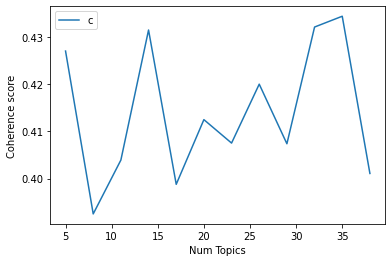

In [36]:
# 정수 인코딩과 빈도수 생성 
dictionary = corpora.Dictionary(book_train_nouns) 
# 출현빈도가 적거나 자주 등장하는 단어는 제거 
# dictionary.filter_extremes(no_below=10, no_above=0.05) 
corpus = [dictionary.doc2bow(text) for text in book_train_nouns]
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus)) 
     
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 
     
# 최적의 토픽 수 찾기 
find_optimal_number_of_topics(dictionary, corpus, book_train_nouns)


![nn](img/최적토픽테스트_start5_step3_max38_필터링X.png)

## 결과

< 5,8,11,14,17,20,23,26,29,32,35,38 >

<출현빈도 필터링O>  
  coherence_values :  [0.38810248394358976, 0.4411537296475936, 0.45515331919757074, 0.4528575031558801, 0.44971625956060984, 0.4749615222911377, 0.40991808070316443, 0.45882209037141397, 0.4482073858921735, 0.4441715494589151, 0.4572752310519807, 0.44660374909936335]

* 20개 - 0.4749615222911377

=> 필터링 안했을 때 보다는 안정적이다...

<출현빈도 필터링X>  
coherence_values :  [0.4270652551304176, 0.3924971585752651, 0.40393028685108495, 0.43153169905013505, 0.39877759205692814, 0.4125075703308897, 0.4075336974683363, 0.4200369298207293, 0.4073890433749906, 0.43216339594092595, 0.43445459689760973, 0.4010838864332929]

* 35개 - 0.43445459689760973

=> 결과가 널뛰는 것 같다...


#### 두 테스트 모두 .50이 넘지 않음